<a href="https://colab.research.google.com/gist/midaslegend786/5da6271d4a7851f26b0d5dab178f5ca6/gold_rates_vs_stock_markets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Analysing gold rates against various stock markets, and forecasting gold rates using machine learning algorithms

The purpose of this task is to analyse gold rate performances against various stock markets. Historical data have been pulled in from Yahoo Finance to enable this study. Various machine learning algorithms were also computed to forecast gold rates and their results have been compared. Attributes were also identified that have great impact on gold rates.

## Importing relevant Python libraries

In [104]:
!pip3 install statsmodels
!pip3 install pmdarima

Defaulting to user installation because normal site-packages is not writeable


Defaulting to user installation because normal site-packages is not writeable


In [105]:
import pandas as pd
import numpy as np
from numpy import exp
from numpy.random import randn
from pandas import DataFrame
from pandas.plotting import scatter_matrix
import datetime as dt

import matplotlib.pyplot as plt
from matplotlib import pyplot
from matplotlib.pylab import rcParams
import seaborn as sns

# sarimax modelling
from sklearn.preprocessing import PowerTransformer
from scipy.stats import boxcox
from scipy.stats import normaltest
from scipy import stats
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pmdarima as pmd
from pmdarima import datasets
from pmdarima import preprocessing
from pmdarima import auto_arima
from pmdarima.pipeline import Pipeline
from sklearn.linear_model import LinearRegression

import warnings
warnings.filterwarnings('ignore')
import sys
import itertools

## (1) Gold ETF data

Here we will pull in Gold ETF data to visualise it's performance against stock markets.

In [106]:
# pulling in data from Gold ETF csv file (obtained from Yahoo Finance)
df_gold = pd.read_csv('SETFGOLD.NS.csv', header=0, parse_dates=True, dayfirst=True)

# visualisation
# df_gold.head()

df_gold.Date = df_gold['Date']
df_gold.Date = pd.to_datetime(df_gold.Date)
df_gold.set_index(df_gold.Date, inplace=True)

# round figures in data to 2 decimal places
df_gold = df_gold.round(decimals=2)

# dropping first column in data
df_gold.drop(columns=df_gold.columns[0], axis=1,  inplace=True)

# filter out dates older than 01-01-2012
df_gold = df_gold.loc['2012-01-01':'2024-01-01']

# visualisation
df_gold.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2022-10-07,45.72,45.75,45.47,45.70,45.70,457904
2022-10-10,45.68,45.68,44.82,44.84,44.84,453874
2022-10-11,44.58,44.92,44.42,44.66,44.66,335843
2022-10-12,44.89,44.90,44.53,44.78,44.78,502071
2022-10-13,44.99,45.05,44.68,44.95,44.95,351132


In [107]:
# checking any missing values
df_gold.isnull().values.any()

False

In [108]:
# checking the size of Gold ETF data
df_gold.shape

(248, 6)

In [109]:
# pulling in some useful statistical information on data
df_gold.describe()

,Open,High,Low,Close,Adj Close,Volume
count,248.000000,248.000000,248.000000,248.000000,248.000000,2.480000e+02
mean,50.429073,50.541935,49.981976,50.183387,50.183387,6.996543e+05
std,2.682420,2.641951,2.622421,2.616501,2.616501,7.885282e+05
min,44.090000,44.370000,43.920000,44.090000,44.090000,0.000000e+00
25%,48.890000,48.960000,48.347500,48.725000,48.725000,2.668188e+05
50%,51.360000,51.465000,51.025000,51.250000,51.250000,4.241535e+05
75%,52.367500,52.435000,51.860000,52.050000,52.050000,6.749580e+05
max,55.000000,55.000000,53.880000,53.980000,53.980000,4.454182e+06


### Computing daily returns on Gold ETF data

In [110]:
# we want to calculate daily returns on Gold ETF data
df_gold['Daily Returns'] = df_gold['Adj Close'].pct_change(1)

# visualisation
df_gold.head()

,Open,High,Low,Close,Adj Close,Volume,Daily Returns
Date,,,,,,,
2022-10-07,45.72,45.75,45.47,45.70,45.70,457904,NaN
2022-10-10,45.68,45.68,44.82,44.84,44.84,453874,-0.018818
2022-10-11,44.58,44.92,44.42,44.66,44.66,335843,-0.004014
2022-10-12,44.89,44.90,44.53,44.78,44.78,502071,0.002687
2022-10-13,44.99,45.05,44.68,44.95,44.95,351132,0.003796


<AxesSubplot:title={'center':'Historical price performance of Gold ETF'}, xlabel='Date'>

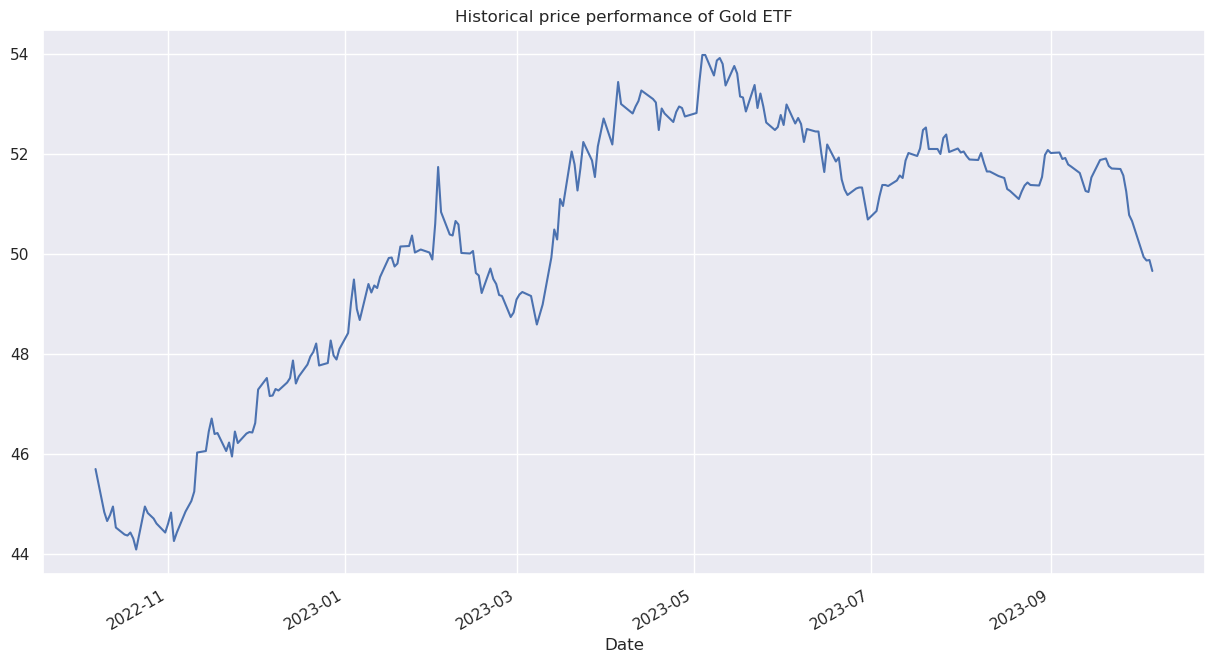

In [111]:
# plot visualisation of how gold performed over time since 2012
df_gold['Adj Close'].plot(title = 'Historical price performance of Gold ETF', figsize=(15,8), linewidth = 1.5)

We can see that the trend had dropped quite significantly but recovered to go higher than initial peaks.

<AxesSubplot:title={'center':'Daily Returns of Gold ETF'}, xlabel='Date'>

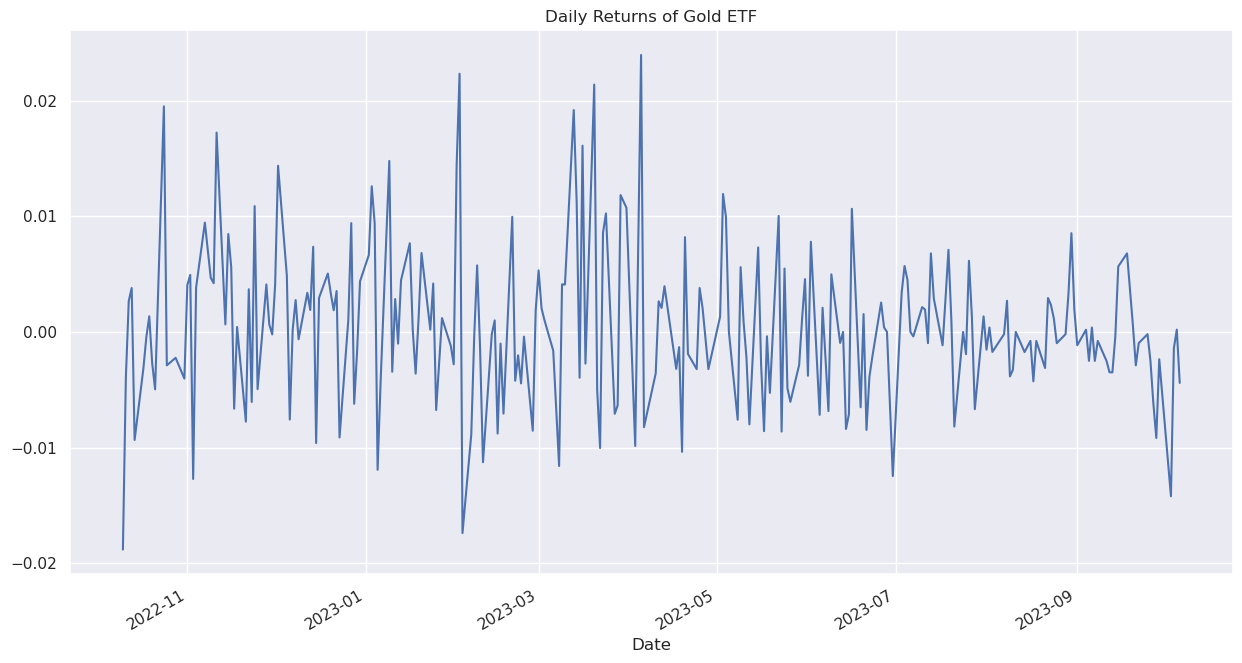

In [112]:
# plot visualisation of gold daily returns over time since 2012
df_gold['Daily Returns'].plot(title = 'Daily Returns of Gold ETF', figsize=(15,8), linewidth=1.5)

We can see that trend is random over time.

## (2) Dow Jones Index data

We will apply the same steps conducted above for Dow Jones Index. This will also be repeated for S&P 500 and USD Index.

In [113]:
# pulling in data from Dow Jones Index csv file (obtained from Yahoo Finance)
import yfinance as yf

#dow = yf.Ticker("^DJI")
# Valid options are 1d, 5d, 1mo, 3mo, 6mo, 1y, 2y, 
#df_dow = dow.history( period="1mo" ,interval = "1d")
#print(df_dow.head())

df_dow = pd.read_csv('^NSEI.csv', header=0, parse_dates=True, dayfirst=True)

df_dow.Date = df_dow['Date']
df_dow.Date = pd.to_datetime(df_dow.Date)
df_dow.set_index(df_dow.Date, inplace=True)

# round figures in data to 2 decimal places
df_dow = df_dow.round(decimals=2)

# dropping first column in data
df_dow.drop(columns=df_dow.columns[0], axis=1,  inplace=True)

# filter out dates older than 01-01-2012
#df_dow = df_dow.loc['2012-01-01':'2024-01-01']

# visualisation
df_dow.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2022-10-07,17287.20,17337.35,17216.95,17314.65,17314.65,216300
2022-10-10,17094.35,17280.15,17064.70,17241.00,17241.00,234000
2022-10-11,17256.05,17261.80,16950.30,16983.55,16983.55,282600
2022-10-12,17025.55,17142.35,16960.05,17123.60,17123.60,256000
2022-10-13,17087.35,17112.35,16956.95,17014.35,17014.35,266400


In [114]:
# checking the size of Dow Jones Index data
df_dow.shape

(248, 6)

In [115]:
# we want to calculate daily returns on Dow Jones Index data
df_dow['Daily Returns'] = df_dow['Adj Close'].pct_change(1)

# visualisation
df_dow.head()

,Open,High,Low,Close,Adj Close,Volume,Daily Returns
Date,,,,,,,
2022-10-07,17287.20,17337.35,17216.95,17314.65,17314.65,216300,NaN
2022-10-10,17094.35,17280.15,17064.70,17241.00,17241.00,234000,-0.004254
2022-10-11,17256.05,17261.80,16950.30,16983.55,16983.55,282600,-0.014932
2022-10-12,17025.55,17142.35,16960.05,17123.60,17123.60,256000,0.008246
2022-10-13,17087.35,17112.35,16956.95,17014.35,17014.35,266400,-0.006380


## (3) S&P 500 data

In [116]:
# pulling in data from S&P 500 csv file (obtained from Yahoo Finance)
df_sp = pd.read_csv('^CRSLDX.csv', header=0, parse_dates=True, dayfirst=True)

df_sp.Date = df_sp['Date']
df_sp.Date = pd.to_datetime(df_sp.Date)
df_sp.set_index(df_sp.Date, inplace=True)

# round figures in data to 2 decimal places
df_sp = df_sp.round(decimals=2)

# dropping first column in data
df_sp.drop(columns=df_sp.columns[0], axis=1,  inplace=True)

# filter out dates older than 01-01-2012
df_sp = df_sp.loc['2012-01-01':'2024-01-01']

# visualisation
df_sp.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2022-10-07,15030.20,15055.65,14943.15,15036.70,15036.68,15358600.0
2022-10-10,14857.00,14989.05,14818.50,14951.65,14951.63,14204600.0
2022-10-11,14980.45,14982.75,14692.55,14721.90,14721.88,14988000.0
2022-10-12,14761.45,14844.85,14676.55,14829.95,14829.93,14189900.0
2022-10-13,14811.20,14832.35,14683.55,14730.30,14730.28,13160400.0


In [117]:
# checking the size of S&P 500 data
df_sp.shape

(248, 6)

In [118]:
# we want to calculate daily returns on S&P 500 data
df_sp['Daily Returns'] = df_sp['Adj Close'].pct_change(1)

# visualisation
df_sp.head()

,Open,High,Low,Close,Adj Close,Volume,Daily Returns
Date,,,,,,,
2022-10-07,15030.20,15055.65,14943.15,15036.70,15036.68,15358600.0,NaN
2022-10-10,14857.00,14989.05,14818.50,14951.65,14951.63,14204600.0,-0.005656
2022-10-11,14980.45,14982.75,14692.55,14721.90,14721.88,14988000.0,-0.015366
2022-10-12,14761.45,14844.85,14676.55,14829.95,14829.93,14189900.0,0.007339
2022-10-13,14811.20,14832.35,14683.55,14730.30,14730.28,13160400.0,-0.006720


## (4) USD Index data

In [119]:
# pulling in data from USD Index csv file (obtained from Yahoo Finance)
df_usd = pd.read_csv('INR=X.csv', header=0, parse_dates=True, dayfirst=True)

df_usd.Date = df_usd['Date']
df_usd.Date = pd.to_datetime(df_usd.Date)
df_usd.set_index(df_usd.Date, inplace=True)

# round figures in data to 2 decimal places
df_usd = df_usd.round(decimals=2)

# dropping first column in data
df_usd.drop(columns=df_usd.columns[0], axis=1,  inplace=True)

# filter out dates older than 01-01-2012
df_usd = df_usd.loc['2012-01-01':'2024-01-01']

# visualisation
df_usd.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2022-10-07,82.35,82.63,82.04,82.35,82.35,0
2022-10-10,82.83,83.06,82.26,82.83,82.83,0
2022-10-11,82.42,82.75,82.14,82.42,82.42,0
2022-10-12,82.27,82.62,82.15,82.27,82.27,0
2022-10-13,82.20,82.89,82.12,82.20,82.20,0


The table above contains NaN so the next step deletes the NaN values.

In [120]:
# dropping all rows containing NaN
df_usd = df_usd.dropna()

# visualisation
df_usd.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2022-10-07,82.35,82.63,82.04,82.35,82.35,0
2022-10-10,82.83,83.06,82.26,82.83,82.83,0
2022-10-11,82.42,82.75,82.14,82.42,82.42,0
2022-10-12,82.27,82.62,82.15,82.27,82.27,0
2022-10-13,82.20,82.89,82.12,82.20,82.20,0


In [121]:
# checking the size of USD Index data
df_usd.shape

(262, 6)

Size of USD Index data bigger than S&P 500, Dow Jones Index and Gold ETF data.

In [122]:
df_usd.info

<bound method DataFrame.info of              Open   High    Low  Close  Adj Close  Volume
Date                                                     
2022-10-07  82.35  82.63  82.04  82.35      82.35       0
2022-10-10  82.83  83.06  82.26  82.83      82.83       0
2022-10-11  82.42  82.75  82.14  82.42      82.42       0
2022-10-12  82.27  82.62  82.15  82.27      82.27       0
2022-10-13  82.20  82.89  82.12  82.20      82.20       0
...           ...    ...    ...    ...        ...     ...
2023-10-03  83.36  83.36  83.13  83.36      83.36       0
2023-10-04  83.23  83.33  83.18  83.23      83.23       0
2023-10-05  83.45  84.70  83.18  83.45      83.45       0
2023-10-06  83.22  83.34  83.08  83.22      83.22       0
2023-10-07  83.11  83.11  83.11  83.11      83.11       0

[262 rows x 6 columns]>

In [123]:
# we want to calculate daily returns on USD Index data
df_usd['Daily Returns'] = df_usd['Adj Close'].pct_change(1)

# visualisation
df_usd.tail()

,Open,High,Low,Close,Adj Close,Volume,Daily Returns
Date,,,,,,,
2023-10-03,83.36,83.36,83.13,83.36,83.36,0,0.003974
2023-10-04,83.23,83.33,83.18,83.23,83.23,0,-0.001560
2023-10-05,83.45,84.70,83.18,83.45,83.45,0,0.002643
2023-10-06,83.22,83.34,83.08,83.22,83.22,0,-0.002756
2023-10-07,83.11,83.11,83.11,83.11,83.11,0,-0.001322


## (5) Merging all data into one place

We find that USD Index data is bigger than that of S&P 500, Dow Jones Index and Gold ETF. Here we will identify dates in USD Index that are not in the other data so the rows can be deleted. Effectively we can then have a data of correct size and without NaN values.

### Let's see how the features had performed over time as percentage change from 2012

In [124]:
# intialising data for fully merged dataframe
df_gold['Gold ETF % Growth'] = (df_gold['Adj Close'] / df_gold['Adj Close'].iat[0]-1)*100
df_dow['Dow Jones % Growth'] = (df_dow['Adj Close'] / df_dow['Adj Close'].iat[0]-1)*100
df_sp['S&P 500 % Growth'] = (df_sp['Adj Close'] / df_sp['Adj Close'].iat[0]-1)*100
df_usd['USD Index % Growth'] = (df_usd['Adj Close'] / df_usd['Adj Close'].iat[0]-1)*100

df_a1 = df_gold[['Gold ETF % Growth']]
df_a2 = df_dow[['Dow Jones % Growth']]
df_a3 = df_sp[['S&P 500 % Growth']]
df_a4 = df_usd[['USD Index % Growth']]

# round figures in dataframe to 2 decimal places
df_a1 = df_a1.round(decimals=2)
df_a2 = df_a2.round(decimals=2)
df_a3 = df_a3.round(decimals=2)
df_a4 = df_a4.round(decimals=2)

# structuring dataframe so that dates contianing NaN are deleted
df_a5 = pd.concat([df_a1, df_a4.reindex(df_a1.index)], axis=1)
df_a6 = pd.merge(df_a2,df_a3, left_index=True, right_index=True)
df_a = pd.merge(df_a5,df_a6, left_index=True, right_index=True)

# visualisation
df_a.tail()

,Gold ETF % Growth,USD Index % Growth,Dow Jones % Growth,S&P 500 % Growth
Date,,,,
2023-09-29,10.85,1.02,13.42,15.00
2023-10-03,9.28,1.23,12.79,14.75
2023-10-04,9.12,1.07,12.25,13.88
2023-10-05,9.15,1.34,12.89,14.36
2023-10-06,8.67,1.06,13.51,15.01


In [125]:
df_a.shape

(248, 4)

In [126]:
# checking any missing values
nan_values = df_a[df_a.isna().any(axis=1)]
print (nan_values)

            Gold ETF % Growth  USD Index % Growth  Dow Jones % Growth  \
Date                                                                    
2022-12-26               4.64                 0.3                4.04   

            S&P 500 % Growth  
Date                          
2022-12-26               NaN  


In [127]:
# dropping all rows containing NaN
df_a = df_a.dropna()

# visualisation
df_a.tail()

,Gold ETF % Growth,USD Index % Growth,Dow Jones % Growth,S&P 500 % Growth
Date,,,,
2023-09-29,10.85,1.02,13.42,15.00
2023-10-03,9.28,1.23,12.79,14.75
2023-10-04,9.12,1.07,12.25,13.88
2023-10-05,9.15,1.34,12.89,14.36
2023-10-06,8.67,1.06,13.51,15.01


In [128]:
# double check if rows had been deleted
df_a.shape

(247, 4)

[]

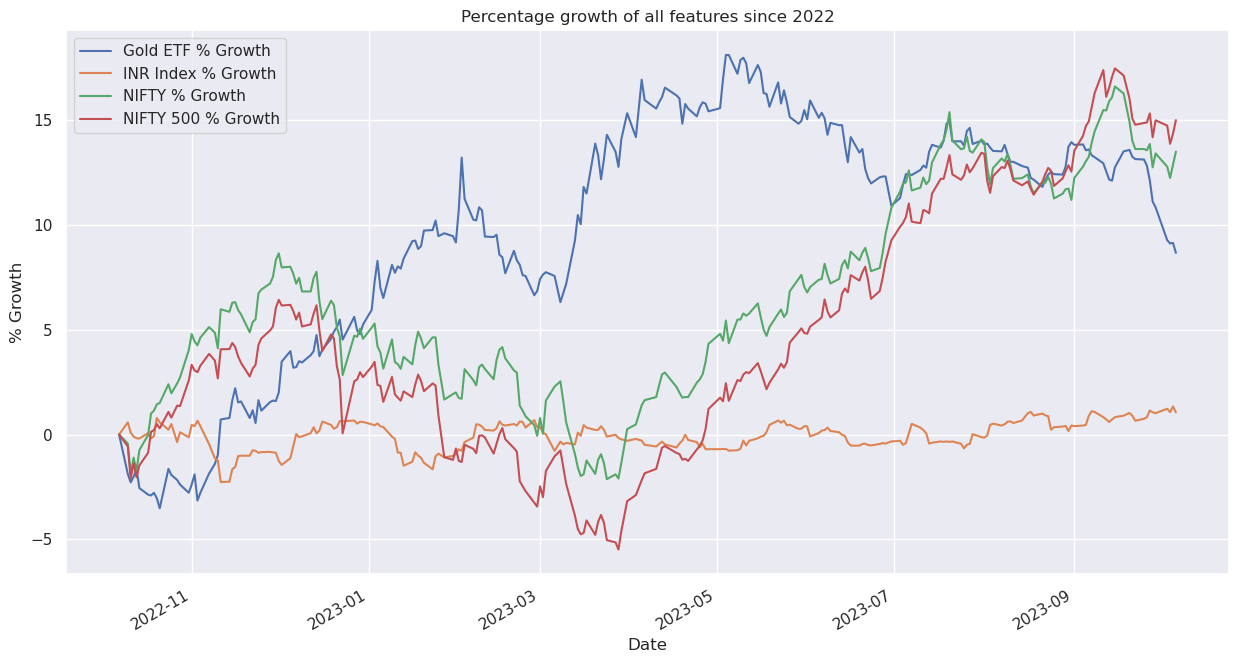

In [144]:
# setting up dataframe for percentage growth visualisation
df_a7 = df_a['Gold ETF % Growth']
df_a8 = df_a['USD Index % Growth']
df_a9 = df_a['Dow Jones % Growth']
df_a10 = df_a['S&P 500 % Growth']

# visualising percentage growth of all features since 2012
g = {'Gold ETF % Growth': df_a7, 'INR Index % Growth': df_a8, 'NIFTY % Growth': df_a9, 'NIFTY 500 % Growth': df_a10}
df_a11 = pd.DataFrame(data = g)
df_A = df_a11.plot(title = 'Percentage growth of all features since 2022', figsize=(15,8), linewidth=1.5)
df_A.set(xlabel="Date", ylabel="% Growth")
df_A.legend(loc='upper left')
df_A.plot()

It can be concluded that S&P 500 and Dow Jones are the best to invest in since 2012 demonstrating at least 200% growth. We can also see that Gold ETF and USD Index have inverse relationship with each other and it is true that Gold ETF weakens if USD Index becomes stronger.

### Visualising daily returns

In [130]:
# intialising data for fully merged dataframe
df_b1 = df_gold[['Adj Close', 'Daily Returns']]
print(df_b1)
df_b2 = df_dow[['Adj Close', 'Daily Returns']]
df_b3 = df_sp[['Adj Close', 'Daily Returns']]
print(df_usd)
df_b4 = df_usd[['Adj Close', 'Daily Returns']]
print(df_b4)

# renaming columns so the features are distinguishible i.e. Gold ETF, Dow Jones, S&P 500 and USD Index
df_b1.rename(columns={'Adj Close': 'Gold ETF Adj Close', 'Daily Returns': 'Gold ETF Daily Returns'}, inplace=True)
df_b2.rename(columns={'Adj Close': 'Dow Jones Adj Close', 'Daily Returns': 'Dow Jones Daily Returns'}, inplace=True)
df_b3.rename(columns={'Adj Close': 'S&P 500 Adj Close', 'Daily Returns': 'S&P 500 Daily Returns'}, inplace=True)
df_b4.rename(columns={'Adj Close': 'USD Index Adj Close', 'Daily Returns': 'USD Index Daily Returns'}, inplace=True)

# structuring dataframe so that dates contianing NaN are deleted
df_b5 = pd.concat([df_b1, df_b4.reindex(df_b1.index)], axis=1)
df_b6 = pd.merge(df_b2, df_b3, left_index=True, right_index=True)
df_b = pd.merge(df_b5, df_b6, left_index=True, right_index=True)

# dropping all rows containing NaN
df_b = df_b.dropna()

# visualisation
df_b.head()

            Adj Close  Daily Returns
Date                                
2022-10-07      45.70            NaN
2022-10-10      44.84      -0.018818
2022-10-11      44.66      -0.004014
2022-10-12      44.78       0.002687
2022-10-13      44.95       0.003796
...               ...            ...
2023-09-29      50.66      -0.002363
2023-10-03      49.94      -0.014212
2023-10-04      49.87      -0.001402
2023-10-05      49.88       0.000201
2023-10-06      49.66      -0.004411

[248 rows x 2 columns]
             Open   High    Low  Close  Adj Close  Volume  Daily Returns  \
Date                                                                       
2022-10-07  82.35  82.63  82.04  82.35      82.35       0            NaN   
2022-10-10  82.83  83.06  82.26  82.83      82.83       0       0.005829   
2022-10-11  82.42  82.75  82.14  82.42      82.42       0      -0.004950   
2022-10-12  82.27  82.62  82.15  82.27      82.27       0      -0.001820   
2022-10-13  82.20  82.89  82.12  82.20 

,Gold ETF Adj Close,Gold ETF Daily Returns,USD Index Adj Close,USD Index Daily Returns,Dow Jones Adj Close,Dow Jones Daily Returns,S&P 500 Adj Close,S&P 500 Daily Returns
Date,,,,,,,,
2022-10-10,44.84,-0.018818,82.83,0.005829,17241.00,-0.004254,14951.63,-0.005656
2022-10-11,44.66,-0.004014,82.42,-0.004950,16983.55,-0.014932,14721.88,-0.015366
2022-10-12,44.78,0.002687,82.27,-0.001820,17123.60,0.008246,14829.93,0.007339
2022-10-13,44.95,0.003796,82.20,-0.000851,17014.35,-0.006380,14730.28,-0.006720
2022-10-14,44.53,-0.009344,82.19,-0.000122,17185.70,0.010071,14815.08,0.005757


In [131]:
df_b.shape

(246, 8)

[]

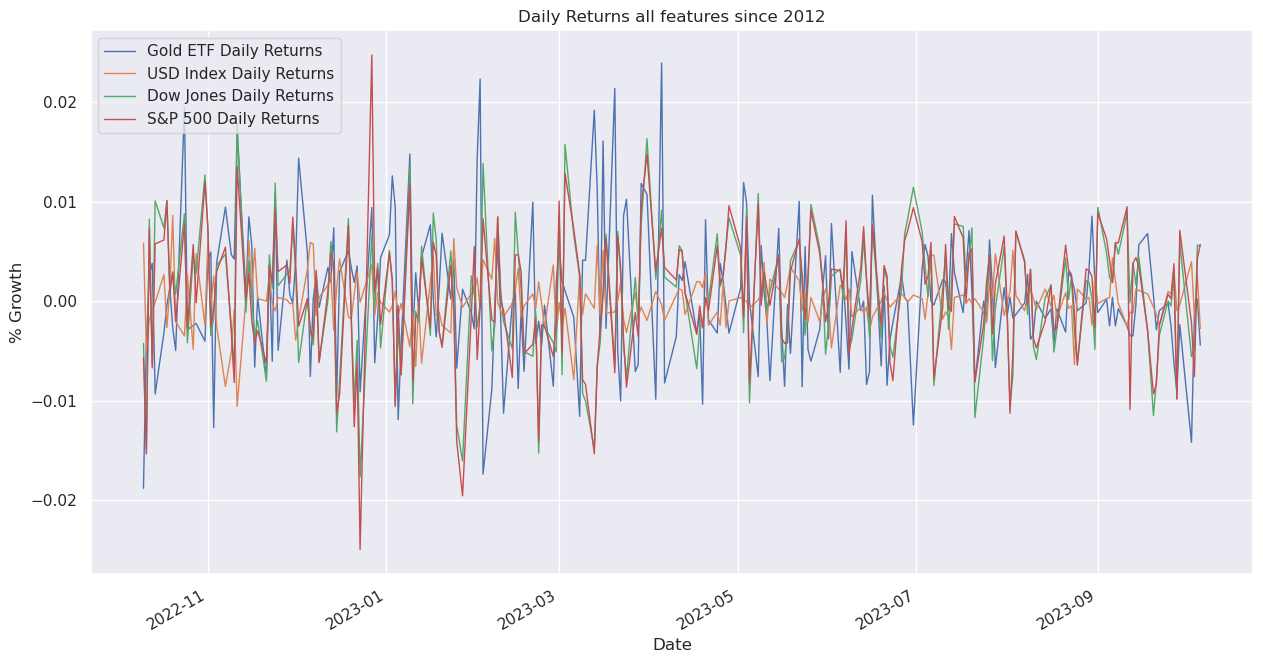

In [132]:
# setting up data for daily returns visualisation
df_b7 = df_b['Gold ETF Daily Returns']
df_b8 = df_b['USD Index Daily Returns']
df_b9 = df_b['Dow Jones Daily Returns']
df_b10 = df_b['S&P 500 Daily Returns']

# visualising percentage growth of all features since 2012
d = {'Gold ETF Daily Returns': df_b7, 'USD Index Daily Returns': df_b8, 'Dow Jones Daily Returns': df_b9, 'S&P 500 Daily Returns': df_b10}
df_b11 = pd.DataFrame(data = d)
df_B = df_b11.plot(title = 'Daily Returns all features since 2012', figsize=(15,8), linewidth=1)
df_B.set(xlabel="Date", ylabel="% Growth")
df_B.legend(loc='upper left')
df_B.plot()

While it is clear that the trends are random, it is still hard to visualise and distinguish between different trends. Next step we will focus on previous 150 records for ease of visualisation.

[]

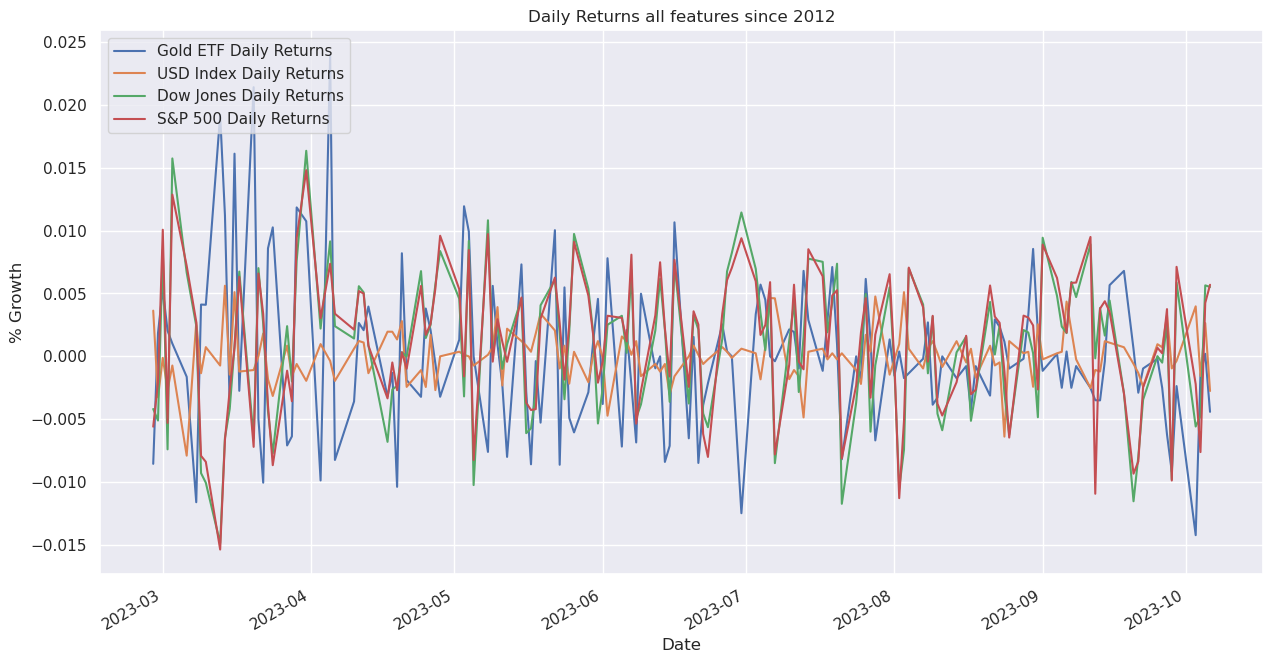

In [133]:
df_b11 = pd.DataFrame(data = d)
df_B = df_b11.iloc[-150:].plot(title = 'Daily Returns all features since 2012', figsize=(15,8), linewidth=1.5)
df_B.set(xlabel="Date", ylabel="% Growth")
df_B.legend(loc='upper left')
df_B.plot()

We can see that the trends are random.

## (6) Visualising correlation and heat maps

### Correlation and heat map on percentage growth of all features

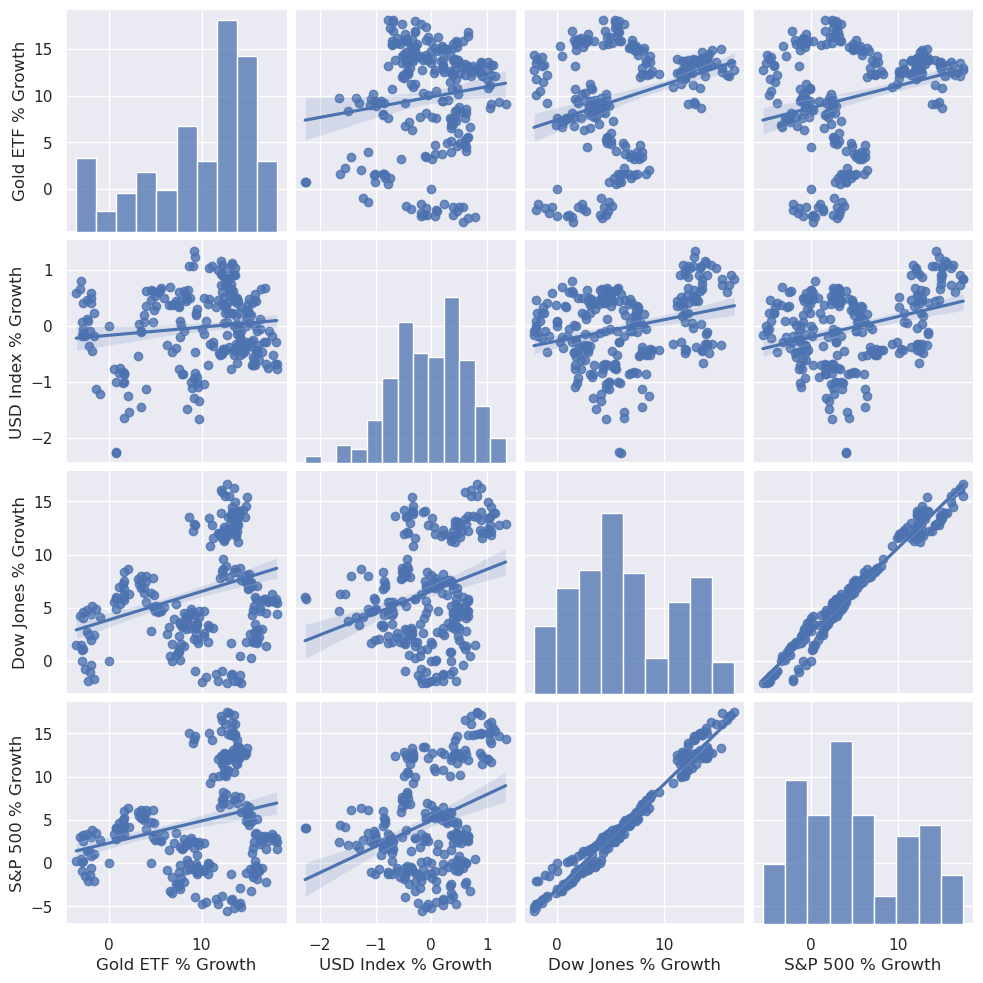

In [134]:
# viewing correlation between data from last 250 records
sns.pairplot(df_a.iloc[-250:], kind='reg')

<AxesSubplot:>

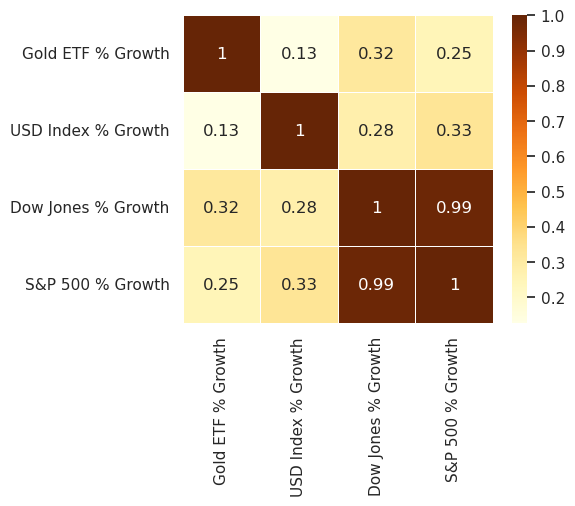

In [135]:
# visualising heat map on percentage growth on all features
sns.set (rc = {'figure.figsize':(5, 4)})
sns.heatmap(df_a.corr(), annot=True, cmap='YlOrBr', linewidth=0.5)

### Correlation  and heat map on daily returns and adj close price of all features

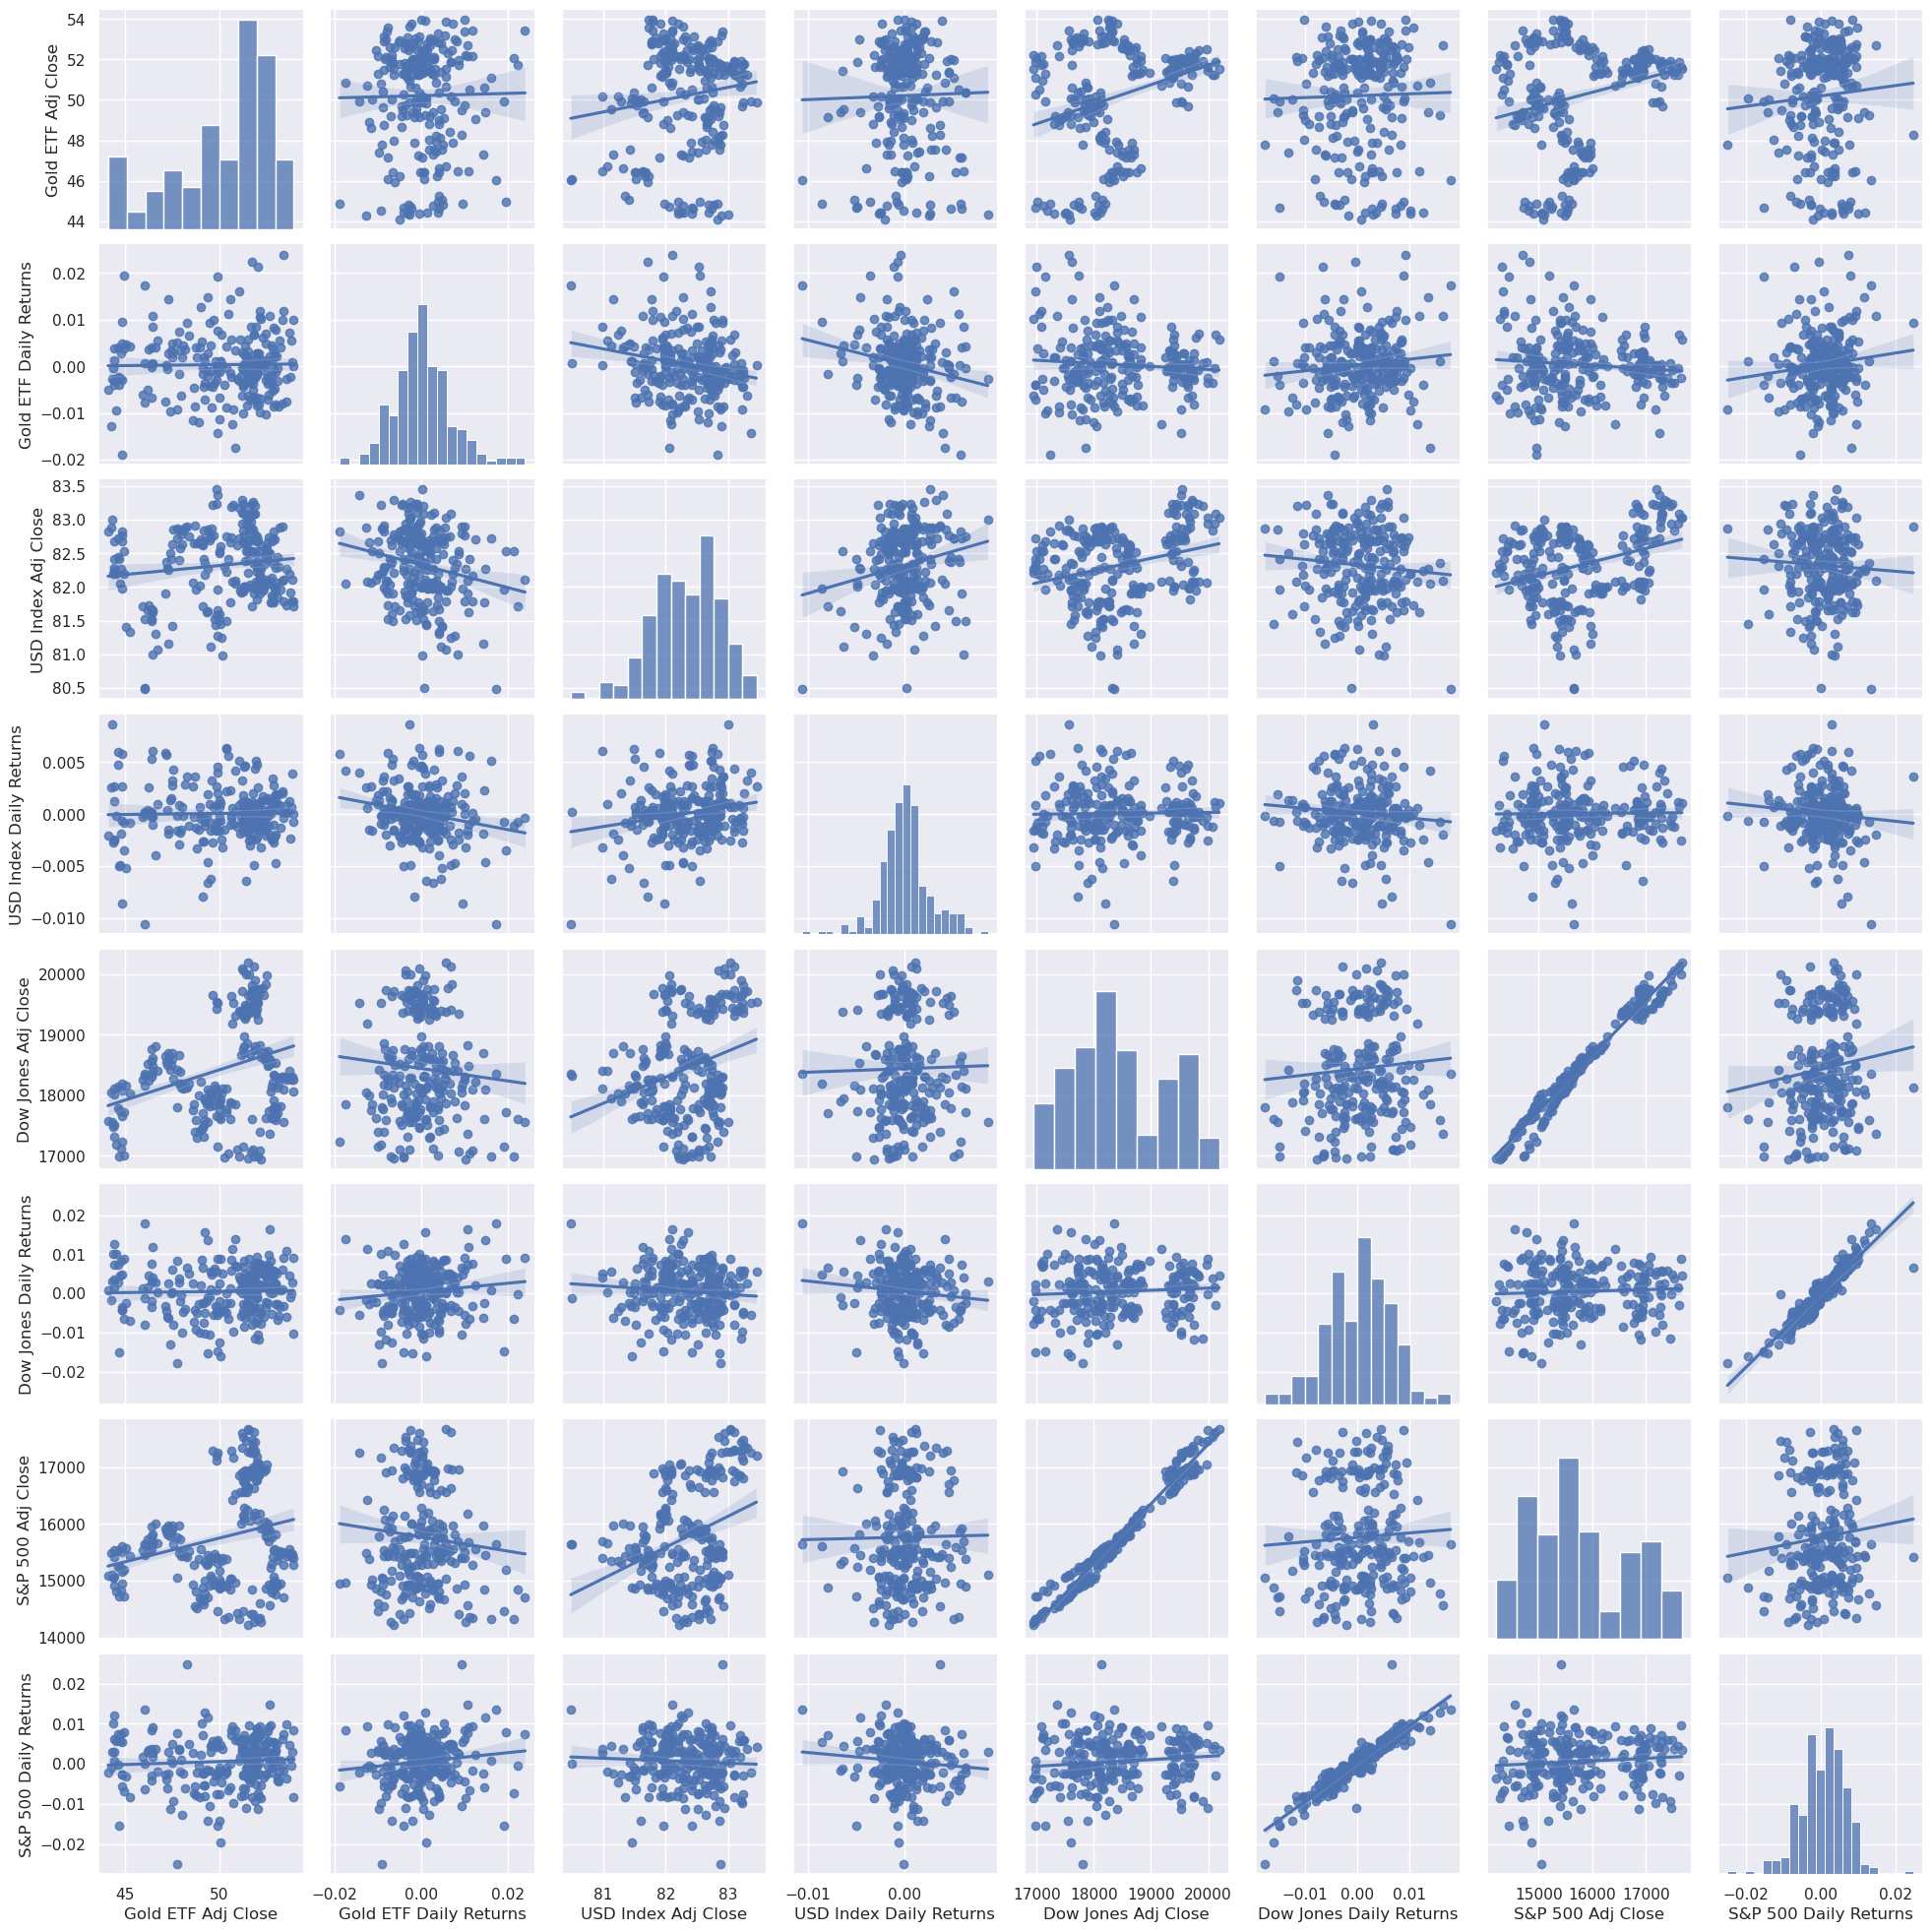

In [136]:
# viewing correlation between data on daily returns and adj close price from last 250 records
sns.pairplot(df_b.iloc[-250:], kind='reg')

<AxesSubplot:>

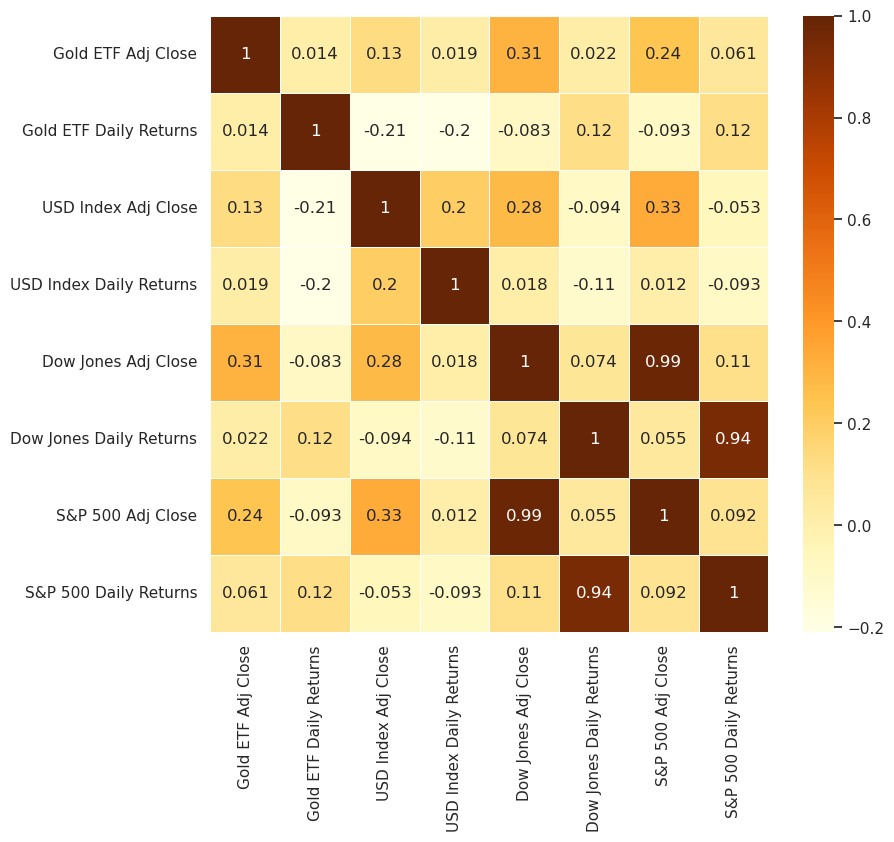

In [137]:
# visualising heat map on daily returns and adj close price on all features
sns.set (rc = {'figure.figsize':(9, 8)})
sns.heatmap(df_b.corr(), annot=True, cmap='YlOrBr', linewidth=0.5)

## (7) Forecasting gold rates against USD Index using SARIMAX modelling

SARIMAX statistical model belonging to a class of models that explains a given time series based on its own past values -i.e.- its own lags and the lagged forecast errors. The SARIMAX model has complex mathematical equations that can be used to forecast future values. This model differs from other models such as ARIMA and SARIMA as it takes account of exogenous variables, or in other words, use external data in forecasting. Some real-world examples of exogenous variables include gold price, oil price, outdoor temperature, exchange rate.

There are certain conditions in order before this model can be conducted. We need to understand whether the time series can be established as 'stationary'. This means whether the time series has: (a) constant mean, (b) it should have constant variance or standard deviation, and (c) auto-covariance should not depend on time.

The time series needs to be stationary to allow forecasting to be computed accurately. There are two ways to check for stationarity of a time series: (1) rolling statistics, and (2) Augmented Dickey-Fuller (ADF) test.

Before we establish whether the data is stationary, we need to understand the time series by decomposing into several components: (1) trend, (2) seasonality, and (3) random noise (residuals).

### Understanding time series through data decomposition

Let’s decompose the data and plot the trend, seasonality, and randomness in the data.

We use statsmodel for seasonal decompose as an additive model and the frequency of the time series, which is the periodicity of the data, which is 365 days for yearly data.

Additive model = trend + seasonality + random noise

In [138]:
# decomposing the data

from statsmodels.stats.stattools import durbin_watson

def plot_stationarity(y, lags):

    y = pd.Series(y)

    # decomposing the data into trend, seasonality and random noise
    decomp = sm.tsa.seasonal_decompose(y, model='add', period=123)

    trend = decomp.trend
    seas = decomp.seasonal
    rand = decomp.resid

    fig = plt.figure()
    fig.set_figheight(10)
    fig.set_figwidth(25)

    ax1 = plt.subplot2grid((3, 3), (0, 0))
    ax2 = plt.subplot2grid((3, 3), (0, 1))
    ax3 = plt.subplot2grid((3, 3), (1, 0))
    ax4 = plt.subplot2grid((3, 3), (1, 1))
    # ax5 = plt.subplot2grid((3, 3), (2, 0))
    # ax6 = plt.subplot2grid((3, 3), (2, 1))

    y.plot(ax=ax1)
    ax1.set_title('Data Run')

    trend.plot(ax=ax2)
    ax2.set_title("Trend Component")

    seas.plot(ax=ax3)
    ax3.set_title("Seasonal Component")

    rand.plot(ax=ax4)
    ax4.set_title("Random Noise")

    # plot_acf(y, lags=lags, zero=False, ax=ax5);
    # plot_pacf(y, lags=lags, zero=False, ax=ax6);

    plt.tight_layout()

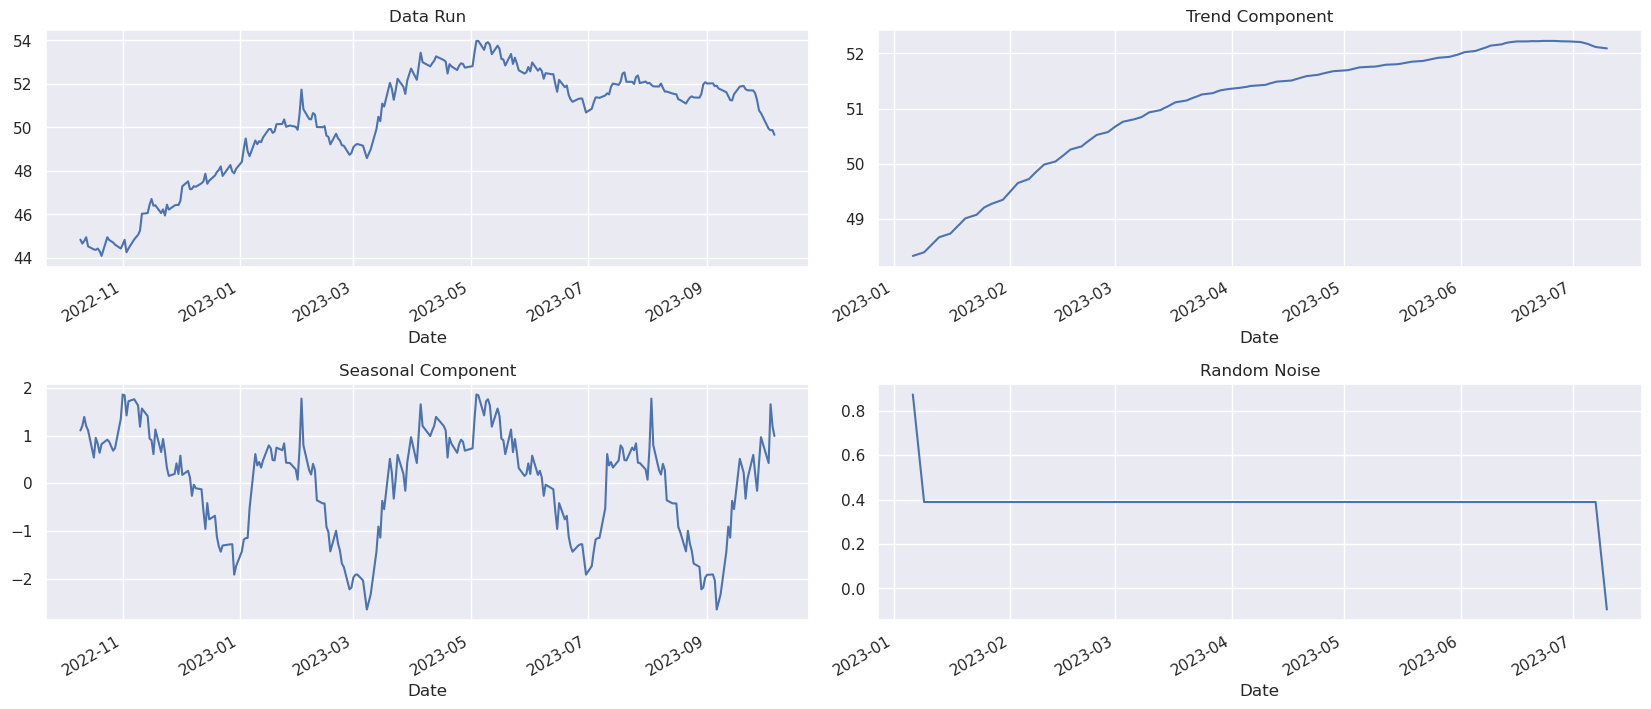

In [139]:
# getting the plots for the data before differencing
plot_stationarity(df_b['Gold ETF Adj Close'].iloc[-730:].dropna(), 25)

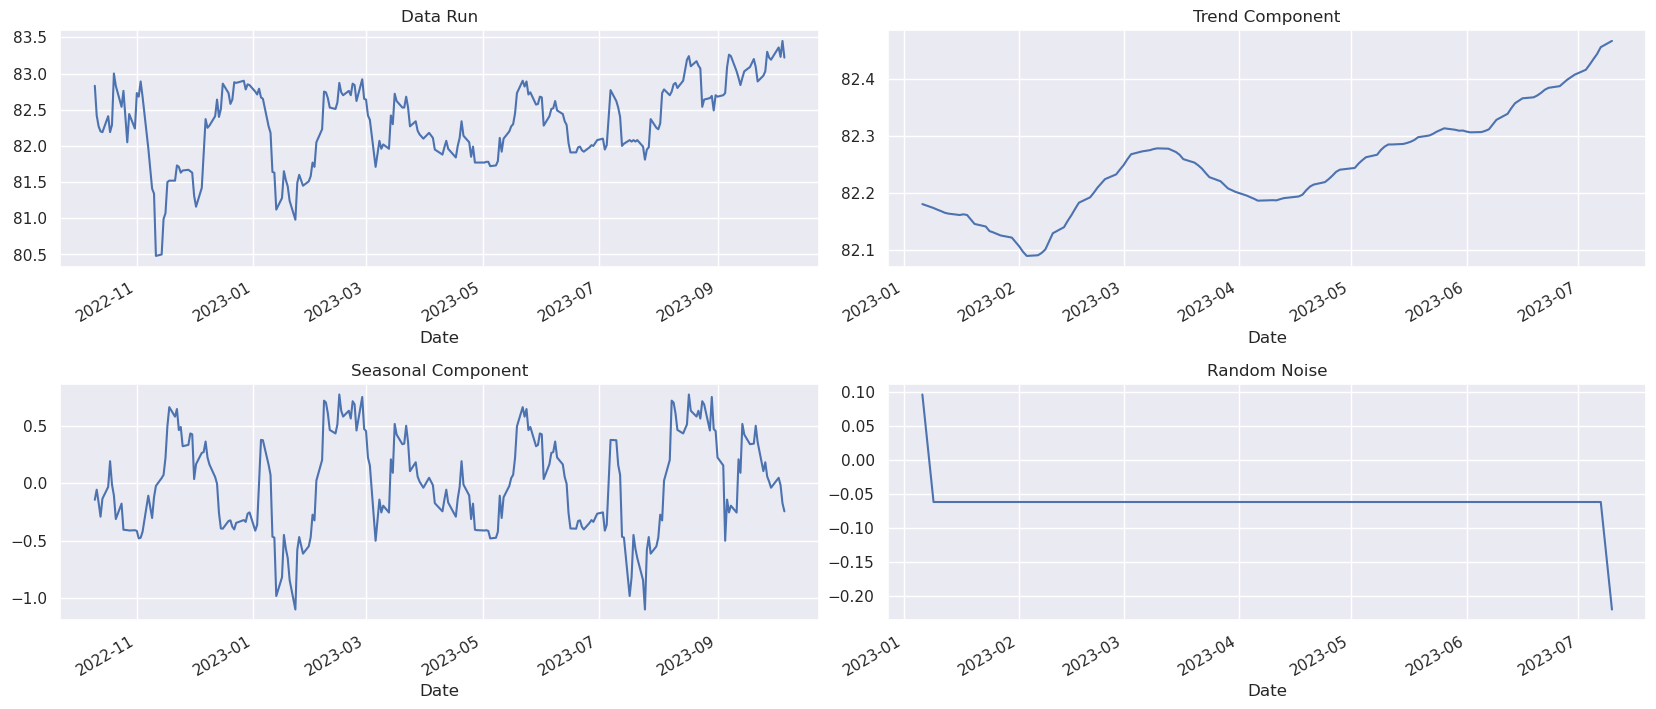

In [140]:
# getting the plots for the data before differencing
plot_stationarity(df_b['USD Index Adj Close'].iloc[-730:].dropna(), 25)

### Checking time series for normality and data transformation

Here we will check whether the time series is normal. Ensuring the time series is normal will provide us with reliable forecasts. The non-normality does not invalidate the forecast model that we are developing but for confidence we will check whether the time series is normal and undergo data transformation where needed to make it normal.

Here we will be using power transforms like the <b>Box-Cox</b> and <b>Yeo-Johnson</b>. They provide an automatic way of performing data transformation and they are provided in the <b>scikit-learn Python machine learning library</b>.

It is possible to apply a power transform directly by calculating the log or the square root of the variable but they may not be the best power transform for the given variable.

Box-Cox and Yeo-Johnson are the two most popular approaches that finds a parameter (lambda) to transform the given variable to a Gaussian probability distribution.

Gold ETF Adj Close
[3.71677099e-06]
USD Index Adj Close
[0.00845958]


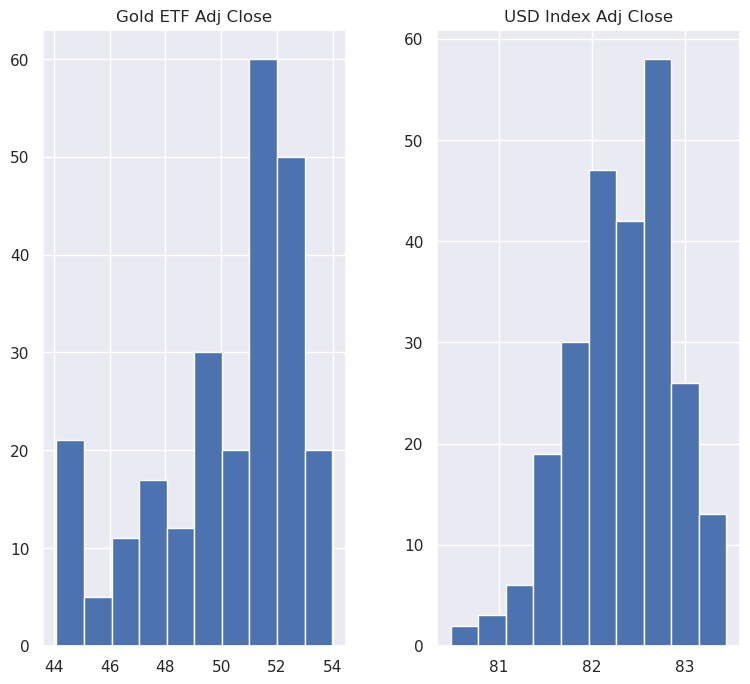

In [141]:
# setting up histograms to see how 'normal' the data is
df_b_new = df_b[['Gold ETF Adj Close', 'USD Index Adj Close']].iloc[-730:]
df_b_new.hist()

# checking for normality
# the test rejects the hypothesis of normality when the p-value is less than or equal to 0.05
print('Gold ETF Adj Close')
print(normaltest(df_b[['Gold ETF Adj Close']].iloc[-730:].dropna())[1])
print('USD Index Adj Close')
print(normaltest(df_b[['USD Index Adj Close']].iloc[-730:].dropna())[1])

# for visualisation
# df_b_new

# df_b_new.shape

### Yeo-Johnson Power Transform

In [142]:
# power transform the data
power = PowerTransformer(method='yeo-johnson', standardize=True)

# reshape data to have rows and columns
df_b_new1 = df_b_new.values.reshape(len(df_b_new),len(df_b_new.columns))
df_b_yj = power.fit_transform(df_b_new1)

# convert the array back to a dataframe
df_b_yjtrans = DataFrame(df_b_yj)

# renaming columns
df_b_yjtrans = df_b_yjtrans.set_axis(['Gold ETF Adj Close YJ', 'USD Index Adj Close YJ'], axis=1, inplace=False)

# structuring dataframe
# df_b_yjtrans.set_index(pd.date_range(start='2020-05-04', periods = 730, freq='B'), inplace=True)
df_b_yjtrans.set_index(df_b_new.index, inplace = True)

# for visualisation
# df_b_yjtrans

# df_b_yjtrans.shape

# histogram of transformed data
df_b_yjtrans.hist()
pyplot.show()

# checking for normality
# the test rejects the hypothesis of normality when the p-value is less than or equal to 0.05
print('Gold ETF Adj Close Yeo-Johnson')
print(normaltest(df_b_yjtrans[['Gold ETF Adj Close YJ']].dropna())[1])
print('USD Index Adj Close Yeo-Johnson')
print(normaltest(df_b_yjtrans[['USD Index Adj Close YJ']].dropna())[1])

TypeError: DataFrame.set_axis() got an unexpected keyword argument 'inplace'

### Box-Cox Power Transform

Here we will need to check if there any negative values as Box-Cox power transform can only work on positive values.

In [ ]:
if df_b_new['Gold ETF Adj Close'].min():
    print('minimum value is: ', df_b_new['Gold ETF Adj Close'].min())
    print('No negative values, OK to run Box-Cox power transform')
else:
    df_b_new['Gold ETF Adj Close'].min()
    print('minimum value is: ', df_b_new['Gold ETF Adj Close'].min())
    print('Data has negative value, NOK to run Box-Cox power transform')

minimum value is:  151.23
No negative values, OK to run Box-Cox power transform


In [ ]:
if df_b_new['USD Index Adj Close'].min():
    print('minimum value is: ', df_b_new['USD Index Adj Close'].min())
    print('No negative values, OK to run Box-Cox power transform')
else:
    df_b_new['USD Index Adj Close'].min()
    print('minimum value is: ', df_b_new['USD Index Adj Close'].min())
    print('Data has negative value, NOK to run Box-Cox power transform')

minimum value is:  89.44
No negative values, OK to run Box-Cox power transform


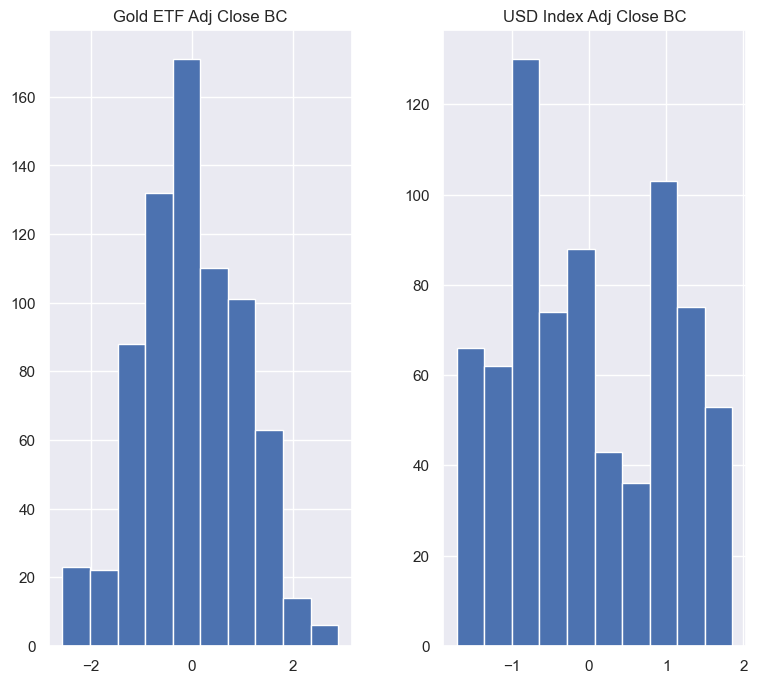

Gold ETF Adj Close Box-Cox
[0.28078052]
USD Index Adj Close Box-Cox
[3.0238481e-196]


In [ ]:
# power transform the data
power = PowerTransformer(method='box-cox')

# reshape data to have rows and columns
df_b_new1 = df_b_new.values.reshape(len(df_b_new),len(df_b_new.columns))
df_b_bc = power.fit_transform(df_b_new1)

# convert the array back to a dataframe
df_b_bctrans = DataFrame(df_b_bc)

# renaming columns
df_b_bctrans = df_b_bctrans.set_axis(['Gold ETF Adj Close BC', 'USD Index Adj Close BC'], axis=1, inplace=False)

# structuring dataframe
df_b_bctrans1 = df_b_bctrans['Gold ETF Adj Close BC']
df_b_bctrans.set_index(df_b_new.index, inplace = True)

# for visualisation
# df_b_bctrans

# df_b_bctrans.shape

# histogram of transformed data
df_b_bctrans.hist()
pyplot.show()

# checking for normality
# the test rejects the hypothesis of normality when the p-value is less than or equal to 0.05
print('Gold ETF Adj Close Box-Cox')
print(normaltest(df_b_bctrans[['Gold ETF Adj Close BC']].dropna())[1])
print('USD Index Adj Close Box-Cox')
print(normaltest(df_b_bctrans[['USD Index Adj Close BC']].dropna())[1])

### Log Power Transform

Here we will try log transform to see how effective it is in normalising data.

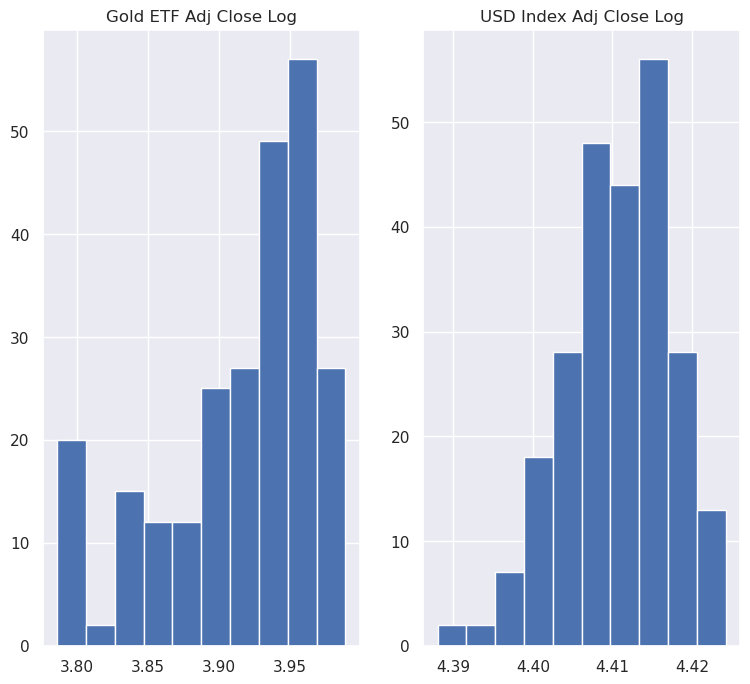

Gold ETF Adj Close Log Transform
[1.02926462e-06]
USD Index Adj Close Log Transform
[0.00571445]


In [ ]:
# applying log to data
df_b_new['Gold ETF Adj Close Log'] = np.log(df_b_new['Gold ETF Adj Close'].dropna())
df_b_new['USD Index Adj Close Log'] = np.log(df_b_new['USD Index Adj Close'].dropna())

# for visualisation
# df_b_new

# df_b_new.shape

# histogram of transformed data

plt.subplot(1, 2, 1)
df_b_new['Gold ETF Adj Close Log'].hist()
plt.title('Gold ETF Adj Close Log')

plt.subplot(1, 2, 2)
df_b_new['USD Index Adj Close Log'].hist()
plt.title('USD Index Adj Close Log')

pyplot.show()

# checking for normality
# the test rejects the hypothesis of normality when the p-value is less than or equal to 0.05
print('Gold ETF Adj Close Log Transform')
print(normaltest(df_b_new[['Gold ETF Adj Close Log']].dropna())[1])
print('USD Index Adj Close Log Transform')
print(normaltest(df_b_new[['USD Index Adj Close Log']].dropna())[1])

### Merging cells into one table containing all power transforms conducted in this exercise

In [ ]:
# merging all transformed data into one table
df_b_trans1 = pd.merge(df_b_new, df_b_yjtrans, left_index=True, right_index=True)
df_b_trans = pd.merge(df_b_trans1, df_b_bctrans, left_index=True, right_index=True)

# for visualisation
df_b_trans.head()

NameError: name 'df_b_yjtrans' is not defined

### Running ADF and KPSS tests

As a general rule:

Neither the ADF test nor the KPSS test will confirm or disconfirm stationarity in isolation. Run both tests to decide if you should difference. If a least one of the tests claims to have found non-stationarity, you should difference.

<b>There are 4 possible combinations of KPSS and ADF test results:</b>

(1) If KPSS and ADF agree that the series is stationary (KPSS with high p-value, ADF with low p-value): Consider it stationary. No need to difference it.

(2) ADF finds a unit root; but KPSS finds that the series is stationary around a deterministic trend (ADF and KPSS with high p-values). Then, the series is trend-stationary and it needs to be detrended. Difference it. Alternatively, a transformation may rid it of its trend.

(3) ADF does not find a unit root; but KPSS claims that it is non-stationary (ADF and KPSS with low p-values). Then, the series is difference-stationary. Difference it.

(4) If KPSS and ADF agree that the series is non-stationary (KPSS with low p-value; ADF with high p-value): Consider it non-stationary. Difference it. Let’s translate this heuristic to Python:

For first-differencing, we take the higher of the orders which ADF and KPSS recommend.

Here we will determine differencing for trend stationarity using ADF and KPSS statisitical tests. We will also conduct OSCB and CH tests to chech differencing for seasonality.

### Running ADF and KPSS tests

In [ ]:
# setting critical p-value as 0.05
alpha = 0.05

# setting ADF test as function
def ADF_statt(x):
     adf_test = adfuller(x, autolag='aic')
     t_stat, p_value, _, _, _, _  = adf_test
     conclusion = 'non-stationary (unit root)' if p_value > alpha else 'stationary'
     res_dict = {'ADF statistic':t_stat, 'p-value':p_value, 'Should we difference?': (p_value > alpha), 'Conclusion': conclusion}
     return res_dict

# call the ADF test:
resADF = ADF_statt(df_b_trans['Gold ETF Adj Close'])

# print dictionary of test results:
print('ADF test result for original data:')
[print(key, ':', value) for key,value in resADF.items()]

ADF test result for original data:
ADF statistic : -2.850837436721691
p-value : 0.051370900936874735
Should we difference? : True
Conclusion : non-stationary (unit root)


[None, None, None, None]

In [ ]:
# setting KPSS test as function
def KPSS_statt(x):
     kpss_test = kpss(x)
     t_stat, p_value, _, critical_values = kpss_test
     conclusion = 'stationary' if p_value > alpha else 'not stationary'
     res_dict = {'ADF statistic':t_stat, 'p-value':p_value, 'Should we difference?': (p_value > alpha), 'Conclusion': conclusion}
     return res_dict

# call the ADF test:
resADF = ADF_statt(df_b_trans['Gold ETF Adj Close'])

# print dictionary of test results:
print('KPSS test result for original data:')
[print(key, ':', value) for key,value in resADF.items()]

KPSS test result for original data:
ADF statistic : -2.850837436721691
p-value : 0.051370900936874735
Should we difference? : True
Conclusion : non-stationary (unit root)


[None, None, None, None]

In [ ]:
# setting ADF test as function
def ADF_statt(x):
     adf_test = adfuller(x, autolag='aic')
     t_stat, p_value, _, _, _, _  = adf_test
     conclusion = 'non-stationary (unit root)' if p_value > alpha else 'stationary'
     res_dict = {'ADF statistic':t_stat, 'p-value':p_value, 'Should we difference?': (p_value > alpha), 'Conclusion': conclusion}
     return res_dict

# call the ADF test:
resADF = ADF_statt(df_b_trans['USD Index Adj Close'])

# print dictionary of test results:
print('ADF test result for original data:')
[print(key, ':', value) for key,value in resADF.items()]

ADF test result for original data:
ADF statistic : -0.7189330738764479
p-value : 0.8417843068247419
Should we difference? : True
Conclusion : non-stationary (unit root)


[None, None, None, None]

In [ ]:
# setting KPSS test as function
def KPSS_statt(x):
     kpss_test = kpss(x)
     t_stat, p_value, _, critical_values = kpss_test
     conclusion = 'stationary' if p_value > alpha else 'not stationary'
     res_dict = {'ADF statistic':t_stat, 'p-value':p_value, 'Should we difference?': (p_value > alpha), 'Conclusion': conclusion}
     return res_dict

# call the ADF test:
resADF = ADF_statt(df_b_trans['USD Index Adj Close'])

# print dictionary of test results:
print('KPSS test result for original data:')
[print(key, ':', value) for key,value in resADF.items()]

KPSS test result for original data:
ADF statistic : -0.7189330738764479
p-value : 0.8417843068247419
Should we difference? : True
Conclusion : non-stationary (unit root)


[None, None, None, None]

### Estimating differencing term for trend stationarity using statistical tests (ADF and KPSS)

In [ ]:
adf_diffs_g = pmd.arima.ndiffs(df_b_trans['Gold ETF Adj Close'], test='adf', max_d=6)
kpss_diffs_g = pmd.arima.ndiffs(df_b_trans['Gold ETF Adj Close'], test='kpss', max_d=6)
n_diffs_g = max(adf_diffs_g, kpss_diffs_g)

print('Gold ETF Adj Close')
print(f'ADF: {adf_diffs_g}')
print(f'KPSS: {kpss_diffs_g}')
print(f'Estimated differencing term: {n_diffs_g}')

Gold ETF Adj Close
ADF: 1
KPSS: 1
Estimated differencing term: 1


In [ ]:
adf_diffs_u = pmd.arima.ndiffs(df_b_trans['USD Index Adj Close'], test='adf', max_d=6)
kpss_diffs_u = pmd.arima.ndiffs(df_b_trans['USD Index Adj Close'], test='kpss', max_d=6)
n_diffs_u = max(adf_diffs_u, kpss_diffs_u)

print('USD Index Adj Close')
print(f'ADF: {adf_diffs_u}')
print(f'KPSS: {kpss_diffs_u}')
print(f'Estimated differencing term: {n_diffs_u}')

USD Index Adj Close
ADF: 1
KPSS: 1
Estimated differencing term: 1


### Estimating differencing term for seasonality using statistical tests (OSCB and CH)

Here we will run the OCSB and CH tests to see if we need differencing for seasonality.

The pmdarima implementations of both tests return the recommended orders of seasonal differencing.

In [ ]:
ocsb_sdiffs_g = pmd.arima.nsdiffs(df_b_trans['Gold ETF Adj Close'], m=365, max_D=2, test='ocsb')
ch_sdiffs_g = pmd.arima.nsdiffs(df_b_trans['Gold ETF Adj Close'], m=365, max_D=2, test='ch')
n_sdiffs_g = max(ocsb_sdiffs_g, ch_sdiffs_g)

print('Gold ETF Adj Close')
print(f'OCSB: {ocsb_sdiffs_g}')
print(f'CH: {ch_sdiffs_g}')
print(f'Estimated seasonal differencing term: {n_sdiffs_g}')

Gold ETF Adj Close
OCSB: 0
CH: 0
Estimated seasonal differencing term: 0


In [ ]:
ocsb_sdiffs_u = pmd.arima.nsdiffs(df_b_trans['USD Index Adj Close'], m=365, max_D=2, test='ocsb')
ch_sdiffs_u = pmd.arima.nsdiffs(df_b_trans['USD Index Adj Close'], m=365, max_D=2, test='ch')
n_sdiffs_u = max(ocsb_sdiffs_u, ch_sdiffs_u)

print('USD Index Adj Close')
print(f'OCSB: {ocsb_sdiffs_u}')
print(f'CH: {ch_sdiffs_u}')
print(f'Estimated seasonal differencing term: {n_sdiffs_u}')

USD Index Adj Close
OCSB: 0
CH: 0
Estimated seasonal differencing term: 0


In [ ]:
# time series before first differencing
# OCSB test that returns the recommended order of seasonal differencing:
n_ocsb = pmd.arima.OCSBTest(m=365).estimate_seasonal_differencing_term(df_b_trans["Gold ETF Adj Close"].dropna())

# CH test that returns the recommended order of seasonal differencing:
n_ch = pmd.arima.CHTest(m=365).estimate_seasonal_differencing_term(df_b_trans['Gold ETF Adj Close'].dropna())

# seasonal differencing recommendation:
print('Gold ETF Adj Close')
print('Time series before first differencing -')
n_seasdiffs = {'Recommended order of seasonal differencing':'', "OCSB recommendation":n_ocsb, "nCH recommendation":n_ch}
[print(key, ":", value) for key,value in n_seasdiffs.items()]

Gold ETF Adj Close
Time series before first differencing -
Recommended order of seasonal differencing : 
OCSB recommendation : 0
nCH recommendation : 0


[None, None, None]

In [ ]:
n_sdiffs_g = max(n_ocsb, n_ch)

print('Gold ETF Adj Close')
print(f'Estimated differencing term: {n_sdiffs_g}')

Gold ETF Adj Close
Estimated differencing term: 0


In [ ]:
# time series before first differencing
# OCSB test that returns the recommended order of seasonal differencing:
n_ocsb = pmd.arima.OCSBTest(m=365).estimate_seasonal_differencing_term(df_b_new['USD Index Adj Close'].dropna())

# CH test that returns the recommended order of seasonal differencing:
n_ch = pmd.arima.CHTest(m=365).estimate_seasonal_differencing_term(df_b_new['USD Index Adj Close'].dropna())

# seasonal differencing recommendation:
print('USD Index Adj Close')
print('Time series before first differencing -')
n_seasdiffs = {'Recommended order of seasonal differencing':'', "OCSB recommendation":n_ocsb, "nCH recommendation":n_ch}
[print(key, ":", value) for key,value in n_seasdiffs.items()]

USD Index Adj Close
Time series before first differencing -
Recommended order of seasonal differencing : 
OCSB recommendation : 0
nCH recommendation : 0


[None, None, None]

In [ ]:
n_sdiffs_u= max(n_ocsb, n_ch)

print('USD Index Adj Close')
print(f'Estimated differencing term: {n_sdiffs_u}')

USD Index Adj Close
Estimated differencing term: 0


### Running ADF and KPSS tests again! This time using trend differencing and seasonal differencing!

In [ ]:
# run ADF and KPSS tests after first differencing AND seasonal differencing:
# use the larger recommended order of first and seasonal differencing, respectively

if n_diffs_g * n_sdiffs_g != 0:                            # both first and seasonal differencing orders?
    df_diff2_g = df_b_new['Gold ETF Adj Close'].diff(n_diffs_g).diff(n_sdiffs_g).dropna()
elif n_diffs_g + n_sdiffs_g != 0:                         # either first or seasonal differencing recommended, but not both?
    df_diff2_g = df_b_new['Gold ETF Adj Close'].diff(max(n_diffs_g,n_sdiffs_g)).dropna()
else:                                               # neither first nor seasonal orders >0
    df_diff2_g = df_b_new['Gold ETF Adj Close']

resADF = ADF_statt(df_diff2_g)
resKPSS = KPSS_statt(df_diff2_g)
test_values = zip(resADF.values(), resKPSS.values())
dict_tests = dict(zip(resADF.keys(), test_values))
df_tests = pd.DataFrame().from_dict(dict_tests).transpose()
df_tests.columns = ['ADF', 'KPSS']
print('Gold ETF Adj Close')
df_tests

Gold ETF Adj Close


,ADF,KPSS
ADF statistic,-20.018692,0.06268
p-value,0.0,0.1
Should we difference?,False,True
Conclusion,stationary,stationary


In [ ]:
# after first AND seasonal differencing: compare ADF, KPSS, OCSB and CH results
n_adf_g = pmd.arima.ndiffs(df_diff2_g, test='adf')
n_kpss_g = pmd.arima.ndiffs(df_diff2_g, test='kpss')
n_ocsb_g = pmd.arima.OCSBTest(m=365).estimate_seasonal_differencing_term(df_diff2_g)
n_ch_g = pmd.arima.OCSBTest(m=365).estimate_seasonal_differencing_term(df_diff2_g)

print('Gold ETF Adj Close')
print('After 1 round of differencing - do we need more?')
n_diffs_g = {'Recommended additional differencing':'', 'ADF first':n_adf_g, 'KPSS first':n_kpss_g,
    'OCSB seasonal':n_ocsb_g, 'CH seasonal':n_ch_g}
[print(key, ":", value) for key,value in n_diffs_g.items()]

Gold ETF Adj Close
After 1 round of differencing - do we need more?
Recommended additional differencing : 
ADF first : 0
KPSS first : 0
OCSB seasonal : 0
CH seasonal : 0


[None, None, None, None, None]

In [ ]:
# run ADF and KPSS tests after first differencing AND seasonal differencing:
# use the larger recommended order of first and seasonal differencing, respectively

if n_diffs_u * n_sdiffs_u!= 0:                            # both first and seasonal differencing orders?
    df_diff2_u = df_b_new['USD Index Adj Close'].diff(n_diffs_u).diff(n_sdiffs_u).dropna()
elif n_diffs_u + n_sdiffs_u != 0:                         # either first or seasonal differencing recommended, but not both?
    df_diff2_u = df_b_new['USD Index Adj Close'].diff(max(n_diffs_u,n_sdiffs_u)).dropna()
else:                                               # neither first nor seasonal orders >0
    df_diff2_u = df_b_new['USD Index Adj Close']

resADF = ADF_statt(df_diff2_u)
resKPSS = KPSS_statt(df_diff2_u)
test_values = zip(resADF.values(), resKPSS.values())
dict_tests = dict(zip(resADF.keys(), test_values))
df_tests = pd.DataFrame().from_dict(dict_tests).transpose()
df_tests.columns = ["ADF", "KPSS"]
print('USD Index Adj Close')
df_tests

USD Index Adj Close


,ADF,KPSS
ADF statistic,-11.91263,0.273603
p-value,0.0,0.1
Should we difference?,False,True
Conclusion,stationary,stationary


In [ ]:
# after first AND seasonal differencing: compare ADF, KPSS, OCSB and CH results
n_adf_u = pmd.arima.ndiffs(df_diff2_u, test="adf")
n_kpss_u = pmd.arima.ndiffs(df_diff2_u, test="kpss")
n_ocsb_u = pmd.arima.OCSBTest(m=12).estimate_seasonal_differencing_term(df_diff2_u)
n_ch_u = pmd.arima.OCSBTest(m=12).estimate_seasonal_differencing_term(df_diff2_u)
print('USD Index Adj Close')
print('After 1 round of differencing - do we need more?')
n_diffs_u = {'Recommended additional differencing':'', 'ADF first':n_adf_u, 'KPSS first':n_kpss_u,
    'OCSB seasonal':n_ocsb_u, 'CH seasonal':n_ch_u}
[print(key, ":", value) for key,value in n_diffs_u.items()]

USD Index Adj Close
After 1 round of differencing - do we need more?
Recommended additional differencing : 
ADF first : 0
KPSS first : 0
OCSB seasonal : 0
CH seasonal : 0


[None, None, None, None, None]

## Forecast predictions using SARIMAX

Here we will be using SARIMAX to predict gold rates.

In [ ]:
# for visualisation
df_b_trans.head()

,Gold ETF Adj Close,USD Index Adj Close,Gold ETF Adj Close Log,USD Index Adj Close Log,Gold ETF Adj Close YJ,USD Index Adj Close YJ,Gold ETF Adj Close BC,USD Index Adj Close BC
Date,,,,,,,,
2020-05-04,160.34,99.48,5.077297,4.599957,-1.274593,1.024181e-14,-1.274593,0.501489
2020-05-05,161.02,99.71,5.081529,4.602266,-1.181745,1.090794e-14,-1.181743,0.534726
2020-05-06,158.95,100.09,5.068590,4.606070,-1.465592,1.201816e-14,-1.465595,0.589469
2020-05-07,161.39,99.89,5.083824,4.604070,-1.131385,1.143530e-14,-1.131383,0.561120
2020-05-08,160.42,99.73,5.077795,4.602467,-1.263650,1.099121e-14,-1.263649,0.537658


<b>Here we will be introducing exogeneous features</b> by adding two months lag to USD Index. USD Index also has influence on gold rates

In [ ]:
# lagging features by 2 months and removing n/a
# df_b_trans['Gold ETF Adj Close 2M Lag'] = df_b_trans['Gold ETF Adj Close Log'].shift(2)
df_b_trans['USD Index Adj Close 2M Lag'] = df_b_trans['USD Index Adj Close'].shift(2)
df_b_trans = df_b_trans.dropna()

# for visualisation
df_b_trans.head()

,Gold ETF Adj Close,USD Index Adj Close,Gold ETF Adj Close Log,USD Index Adj Close Log,Gold ETF Adj Close YJ,USD Index Adj Close YJ,Gold ETF Adj Close BC,USD Index Adj Close BC,USD Index Adj Close 2M Lag
Date,,,,,,,,,
2020-05-06,158.95,100.09,5.068590,4.606070,-1.465592,1.201816e-14,-1.465595,0.589469,99.48
2020-05-07,161.39,99.89,5.083824,4.604070,-1.131385,1.143530e-14,-1.131383,0.561120,99.71
2020-05-08,160.42,99.73,5.077795,4.602467,-1.263650,1.099121e-14,-1.263649,0.537658,100.09
2020-05-11,159.42,100.24,5.071542,4.607567,-1.400827,1.246225e-14,-1.400829,0.610975,99.89
2020-05-12,160.04,99.93,5.075424,4.604470,-1.315678,1.157408e-14,-1.315679,0.566008,99.73


<b>Here we will introduce naive forecasting</b> and it is a simple time series forecasting method that uses the last observed value from the same season in the previous year as the prediction for the current season. It assumes that historical patterns repeat annually.

In [ ]:
# by definition, naive forecast is using last months results as the prediction for this month.

df_b_trans['Naive Forecast Gold'] = df_b_trans['Gold ETF Adj Close'].shift(1)

# for visualisation
df_b_trans.head()

,Gold ETF Adj Close,USD Index Adj Close,Gold ETF Adj Close Log,USD Index Adj Close Log,Gold ETF Adj Close YJ,USD Index Adj Close YJ,Gold ETF Adj Close BC,USD Index Adj Close BC,USD Index Adj Close 2M Lag,Naive Forecast Gold
Date,,,,,,,,,,
2020-05-06,158.95,100.09,5.068590,4.606070,-1.465592,1.201816e-14,-1.465595,0.589469,99.48,NaN
2020-05-07,161.39,99.89,5.083824,4.604070,-1.131385,1.143530e-14,-1.131383,0.561120,99.71,158.95
2020-05-08,160.42,99.73,5.077795,4.602467,-1.263650,1.099121e-14,-1.263649,0.537658,100.09,161.39
2020-05-11,159.42,100.24,5.071542,4.607567,-1.400827,1.246225e-14,-1.400829,0.610975,99.89,160.42
2020-05-12,160.04,99.93,5.075424,4.604470,-1.315678,1.157408e-14,-1.315679,0.566008,99.73,159.42


In [ ]:
df_b_trans.describe()

,Gold ETF Adj Close,USD Index Adj Close,Gold ETF Adj Close Log,USD Index Adj Close Log,Gold ETF Adj Close YJ,USD Index Adj Close YJ,Gold ETF Adj Close BC,USD Index Adj Close BC,USD Index Adj Close 2M Lag,Naive Forecast Gold
count,728.000000,728.000000,728.000000,728.000000,728.000000,7.280000e+02,728.000000,728.000000,728.000000,727.000000
mean,170.123860,97.767692,5.135492,4.580507,0.003374,-3.755390e-17,0.003374,-0.001633,97.758365,170.107593
std,7.746548,6.402963,0.045526,0.064237,0.999980,2.045746e-14,0.999980,1.001691,6.397812,7.739429
min,151.230000,89.440000,5.018802,4.493568,-2.557090,-3.488876e-14,-2.557133,-1.708776,89.440000,151.230000
25%,164.937500,92.627500,5.105567,4.528586,-0.654206,-1.666722e-14,-0.654201,-0.816019,92.627500,164.935000
50%,169.415000,95.965000,5.132351,4.563984,-0.066078,-1.859624e-15,-0.066074,-0.089936,95.965000,169.410000
75%,175.652500,103.415000,5.168508,4.638750,0.728342,2.055300e-14,0.728341,1.007376,103.415000,175.640000
max,193.890000,114.110000,5.267291,4.737163,2.901774,3.794187e-14,2.901775,1.857365,114.110000,193.890000


In [ ]:
# split dataset into training and test set

# important global variables
ALPHA = 0.05                       # significance level
MSEAS = 7                          # seasonality
TRAINP = 550                       # splitting data train and test

dfinput = df_b_trans['Gold ETF Adj Close'].dropna()
dtrain = df_b_trans.iloc[:TRAINP].copy()
dtest = df_b_trans.iloc[TRAINP:].copy()

# selecting the non differenced values as AUTO ARIMA will do the differencing itself
y = df_b_trans['Gold ETF Adj Close']
y_train = dtrain['Gold ETF Adj Close']
y_test = dtest['Gold ETF Adj Close']

In [ ]:
dtest.tail()

,Gold ETF Adj Close,USD Index Adj Close,Gold ETF Adj Close Log,USD Index Adj Close Log,Gold ETF Adj Close YJ,USD Index Adj Close YJ,Gold ETF Adj Close BC,USD Index Adj Close BC,USD Index Adj Close 2M Lag,Naive Forecast Gold
Date,,,,,,,,,,
2023-03-21,180.37,103.26,5.195010,4.637250,1.311028,2.020606e-14,1.311023,0.990269,103.71,183.84
2023-03-22,183.44,102.35,5.211888,4.628398,1.682256,1.804112e-14,1.682249,0.883715,103.28,180.37
2023-03-23,185.74,102.53,5.224348,4.630155,1.956407,1.848521e-14,1.956400,0.905221,103.26,183.44
2023-03-24,183.65,103.12,5.213032,4.635893,1.707426,1.990075e-14,1.707419,0.973650,102.35,185.74
2023-03-27,181.95,102.86,5.203732,4.633369,1.502850,1.926237e-14,1.502844,0.943346,102.53,183.65


In [ ]:
# run auto ARIMA hyperparameter search for the training dataset
# the procedure will apply the pipeline transformations to the original data
# Box-Cox transformation and differencing

from pmdarima.pipeline import Pipeline

n_diff = 1
ns_diff = 0

if n_diff == 0:
    booStat = True
else:
    booStat = False

# calling the exogenous features and note that AutoARIMA will not run any transformations for this features
# it is imperative that transformations be performed on these prior to referencing them in the model

exogenous_features = df_b_trans['USD Index Adj Close 2M Lag']

pipe = Pipeline([
    ('boxcox', pmd.preprocessing.BoxCoxEndogTransformer(lmbda2=1e-6)),
    ('arima', pmd.AutoARIMA(exogenous_features = exogenous_features,
                            d=n_diff, D=ns_diff, m=MSEAS, seasonal=True, stationary=booStat,
                            max_p=7,max_q=7,max_P=7,max_Q=7, max_d=1, max_D=1, max_order=5,
                            stepwise=True, alpha=ALPHA,
                            suppress_warnings=True, trace=True)
                            )])

pipe.fit(y_train)
pipe.summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[7] intercept   : AIC=-11596.121, Time=3.50 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=-12059.482, Time=0.16 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=-12056.262, Time=0.36 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=-12120.398, Time=0.35 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=-13250.892, Time=0.06 sec
 ARIMA(0,1,0)(1,0,0)[7] intercept   : AIC=-12058.296, Time=0.26 sec
 ARIMA(0,1,0)(0,0,1)[7] intercept   : AIC=-12010.522, Time=0.26 sec
 ARIMA(0,1,0)(1,0,1)[7] intercept   : AIC=-12335.938, Time=0.35 sec
 ARIMA(1,1,0)(0,0,0)[7] intercept   : AIC=-12057.457, Time=0.20 sec
 ARIMA(0,1,1)(0,0,0)[7] intercept   : AIC=-11604.900, Time=0.13 sec
 ARIMA(1,1,1)(0,0,0)[7] intercept   : AIC=-13038.688, Time=0.27 sec

Best model:  ARIMA(0,1,0)(0,0,0)[7]          
Total fit time: 5.909 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  550
Model:               SARIMAX(0, 1, 0)   Log Likelihood                6626.446
Date:                Wed, 07 Jun 2023   AIC                         -13250.892
Time:                        20:14:24   BIC                         -13246.584
Sample:                             0   HQIC                        -13249.208
                                - 550                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      4.998e-12   8.12e-11      0.062      0.951   -1.54e-10    1.64e-10
===================================================================================
Ljung-Box (L1) (Q):                   1.30   Jarque-Bera (JB):               108.01
Prob(Q):                              0.25   Prob(JB):                         0.00
Heteroskedasticity (H):               0.70   Skew:                            -0.70
Prob(H) (two-sided):                  0.02   Kurtosis:                         4.66
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<b>Here we see there little differencing needed</b> due to values in the orders i.e. ARIMA(0,1,0)(0,0,0)[7]

In [ ]:
# ARIMA(0,1,0)(0,0,0)[7]

mod = SARIMAX(df_b_trans['Gold ETF Adj Close'], order=(0,1,0), seasonal_order=(0,0,0,7))
res = mod.fit(disp=0)
start = len(dtrain)
end = len(dtrain) + len(dtest) - 1
SARIMAX = res.predict(start, end).rename('SARIMAX')

In [ ]:
df_SARIMAX = pd.DataFrame(SARIMAX)

dtest1 = pd.merge(dtest,df_SARIMAX,
             left_index=True,
             right_index=True)

dtest1.tail()

,Gold ETF Adj Close,USD Index Adj Close,Gold ETF Adj Close Log,USD Index Adj Close Log,Gold ETF Adj Close YJ,USD Index Adj Close YJ,Gold ETF Adj Close BC,USD Index Adj Close BC,USD Index Adj Close 2M Lag,Naive Forecast Gold,SARIMAX
Date,,,,,,,,,,,
2023-03-21,180.37,103.26,5.195010,4.637250,1.311028,2.020606e-14,1.311023,0.990269,103.71,183.84,183.84
2023-03-22,183.44,102.35,5.211888,4.628398,1.682256,1.804112e-14,1.682249,0.883715,103.28,180.37,180.37
2023-03-23,185.74,102.53,5.224348,4.630155,1.956407,1.848521e-14,1.956400,0.905221,103.26,183.44,183.44
2023-03-24,183.65,103.12,5.213032,4.635893,1.707426,1.990075e-14,1.707419,0.973650,102.35,185.74,185.74
2023-03-27,181.95,102.86,5.203732,4.633369,1.502850,1.926237e-14,1.502844,0.943346,102.53,183.65,183.65


In [143]:
dtest1[['Naive Forecast Gold', 'Gold ETF Adj Close', 'SARIMAX']].plot(legend=True, figsize=(15,5), linewidth=3)
#SARIMAX.plot(legend=True, linewidth=3)
#plt.show()

NameError: name 'dtest1' is not defined

In [ ]:
df_b.head()

,Gold ETF Adj Close,Gold ETF Daily Returns,USD Index Adj Close,USD Index Daily Returns,Dow Jones Adj Close,Dow Jones Daily Returns,S&P 500 Adj Close,S&P 500 Daily Returns
Date,,,,,,,,
2012-01-04,156.71,0.005067,80.09,0.006029,12418.42,0.001697,1277.30,0.000188
2012-01-05,157.78,0.006828,80.94,0.010613,12415.70,-0.000219,1281.06,0.002944
2012-01-06,157.20,-0.003676,81.24,0.003706,12359.92,-0.004493,1277.81,-0.002537
2012-01-09,156.50,-0.004453,81.05,-0.002339,12392.69,0.002651,1280.70,0.002262
2012-01-10,158.64,0.013674,80.80,-0.003085,12462.47,0.005631,1292.08,0.008886


In [ ]:
from pandas.io import gbq

df_b = df_b.rename(columns={'Gold ETF Adj Close': 'Gold_ETF_Adj_Close', 'Gold ETF Daily Returns': 'Gold_ETF_Daily_Returns',
                     'USD Index Adj Close': 'USD_Index_Adj_Close', 'USD Index Daily Returns': 'USD_Index_Daily_Returns',
                     'Dow Jones Adj Close': 'Dow_Jones_Adj_Close', 'Dow Jones Daily Returns': 'Dow_Jones_Daily_Returns',
                     'S&P 500 Adj Close': 'SP_500_Adj_Close', 'S&P 500 Daily Returns': 'SP_500_Daily_Returns'})

df_b.head()

df_b.to_gbq(destination_table = 'stock_markets.stock_data2', project_id = 'probable-symbol-389018', if_exists = 'replace')

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 1650.00it/s]


In [ ]:
Query = """SELECT * FROM `probable-symbol-389018.stock_markets.stock_data2` ORDER BY Date ASC"""
stock_data1 = gbq.read_gbq(Query, project_id="probable-symbol-389018")
stock_data1.head(10)

,Date,Gold_ETF_Adj_Close,Gold_ETF_Daily_Returns,USD_Index_Adj_Close,USD_Index_Daily_Returns,Dow_Jones_Adj_Close,Dow_Jones_Daily_Returns,SP_500_Adj_Close,SP_500_Daily_Returns
0,2012-01-04,156.71,0.005067,80.09,0.006029,12418.42,0.001697,1277.30,0.000188
1,2012-01-05,157.78,0.006828,80.94,0.010613,12415.70,-0.000219,1281.06,0.002944
2,2012-01-06,157.20,-0.003676,81.24,0.003706,12359.92,-0.004493,1277.81,-0.002537
3,2012-01-09,156.50,-0.004453,81.05,-0.002339,12392.69,0.002651,1280.70,0.002262
4,2012-01-10,158.64,0.013674,80.80,-0.003085,12462.47,0.005631,1292.08,0.008886
5,2012-01-11,159.67,0.006493,81.35,0.006807,12449.45,-0.001045,1292.48,0.000310
6,2012-01-12,160.38,0.004447,80.77,-0.007130,12471.02,0.001733,1295.50,0.002337
7,2012-01-13,159.26,-0.006983,81.43,0.008171,12422.06,-0.003926,1289.09,-0.004948
8,2012-01-17,160.50,0.007786,81.18,-0.003070,12482.07,0.004831,1293.67,0.003553
9,2012-01-18,161.60,0.006854,80.60,-0.007145,12578.95,0.007762,1308.04,0.011108


In [ ]:
import pandas as pd
import pandas_gbq

from google.cloud import bigquery
%load_ext google.cloud.bigquery

# set your default project here
pandas_gbq.context.project = 'bigquery-public-data.stock_markets.stock_data2'
# pandas.gbq.context.dialect = 'standard'

The google.cloud.bigquery extension is already loaded. To reload it, use:
  %reload_ext google.cloud.bigquery


In [ ]:
%%bigquery
SELECT *
FROM `bigquery-public-data.stock_markets.stock_data2`
LIMIT 1000

Executing query with job ID: f250b6f6-3ff5-4699-8a88-a92da0c642a8
Query executing: 0.78s


ERROR:
 403 Access Denied: Table bigquery-public-data:stock_markets.stock_data2: User does not have permission to query table bigquery-public-data:stock_markets.stock_data2, or perhaps it does not exist in location US.

Location: US
Job ID: f250b6f6-3ff5-4699-8a88-a92da0c642a8

